### This notebook actually calculates a representative subsample of GBS. ROC Curves are therefore combined with increasing brightness to demonstrate the progress.

In [10]:
from pathlib import Path
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

path = Path(os.getcwd()).parent

#this method tries to assess the performance of the pu learning method. it takes the puAUC and estimates the actual AUC.
def puROC(auc, pos):
    return (auc - pos/2)/(1-pos)


# this might seem a little confusing: 
#puAUC is the calculated AUC for the binary classification setting. The positive unlabeled setting AUC is AUC.
def roc(y_test, preds, iteration, name):
    alpha = min(iteration+0.2,0.8)
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    #plt.title('Iteration: '+ str(name))
    plt.figure(figsize=(12,8))
    label = 'puAUC = %0.2f' % roc_auc + '\n AUC = %0.2f' % puROC(roc_auc, 0.29)
    plt.plot(fpr, tpr, 'black', label = label, alpha=alpha)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--', alpha=alpha)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(os.path.join(path, 'tex/fig/roc/'+str(name)+'.png'))
    plt.show()
    return roc_auc

In [11]:
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')

gbs = gbs.fillna(gbs.median())
gesis = gesis.fillna(gesis.median())

gbs['Umfrage'] = 1
gesis['Umfrage'] = 0

In [12]:
gbs.columns

Index(['GBS-CODE', 'Gruppe', 'Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Nettoeinkommen Haushalt', 'Schlechter Schlaf', 'Leben genießen',
       'Zu Nichts aufraffen', 'Alles anstrengend', 'Wahlteilnahme',
       'Wahlabsicht', 'Desinteresse Politiker', 'Zufriedenheit Leben', 'Aktiv',
       'Verärgert', 'Wach', 'Nervös', 'Ängstlich', 'Zurueckhaltend',
       'leicht Vertrauen', 'Faulheit', 'Entspannt',
       'wenig kuenstlerisches Interesse', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll', 'Druck', 'Optimismus Zukunft',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Umfrage'],
      dtype='object')

In [3]:
gesis.drop(columns = ['GESIS-CODE'], axis=1, inplace = True)
gbs.drop(columns = ['GBS-CODE', 'Gruppe'], axis=1, inplace = True)

drop = ['Personen im Haushalt', 'Druck', 'Optimismus Zukunft', 'Geburtsland', 'Nationalitaet',
       'Familienstand', 'Hoechster Bildungsabschluss', 'Berufliche Ausbildung',
       'Berufsgruppe', 'Leben genießen', 'Zu Nichts aufraffen',
       'Alles anstrengend', 'Zufriedenheit Leben', 'Aktiv', 'Verärgert',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Wach', 'Nervös', 'Ängstlich', 'Zurueckhaltend',
       'Nettoeinkommen Selbst', 'Nettoeinkommen Haushalt', 'Schlechter Schlaf',
       'Wahlabsicht', 'Desinteresse Politiker', 'Erwerbstaetigkeit', 'Geschlecht', 'Geburtsjahr', 'Wahlteilnahme']

gbs.drop(columns=drop, axis=1, inplace=True)
gesis.drop(columns=drop, axis=1, inplace=True)

gbs_base = gbs.copy()

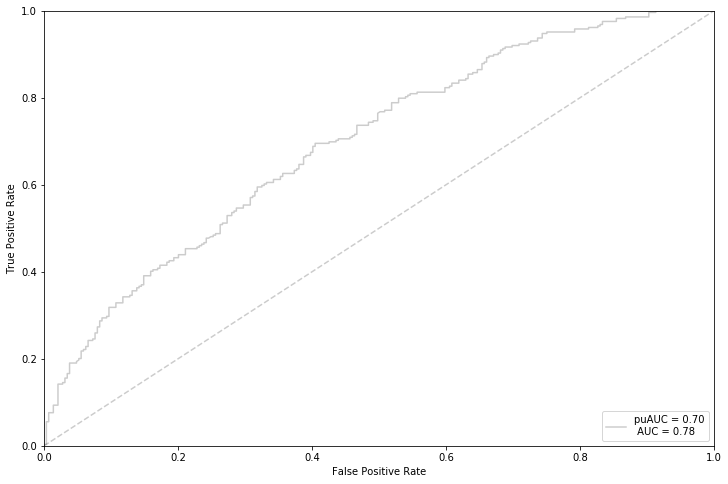

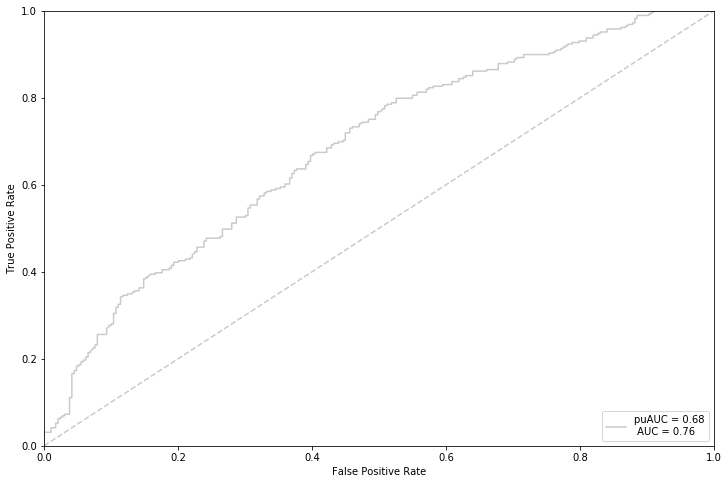

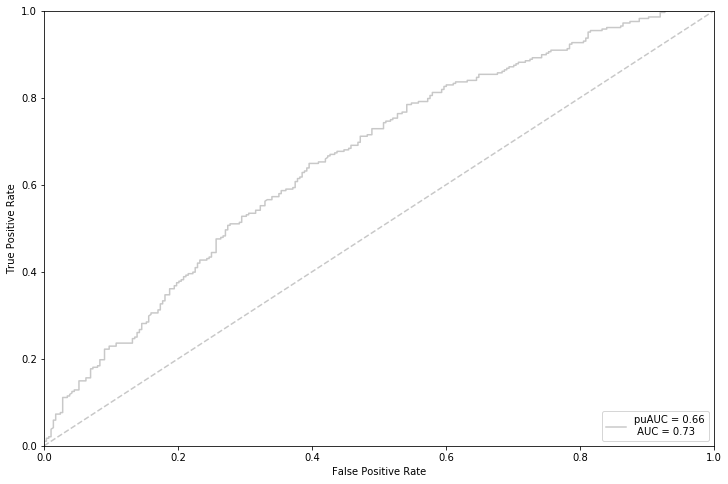

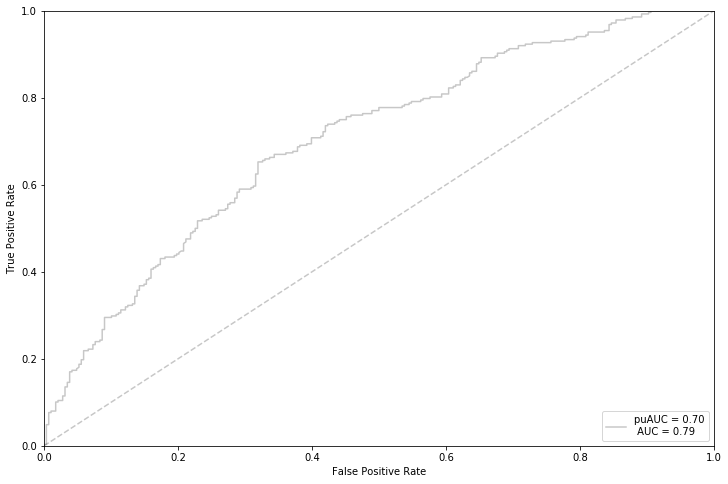

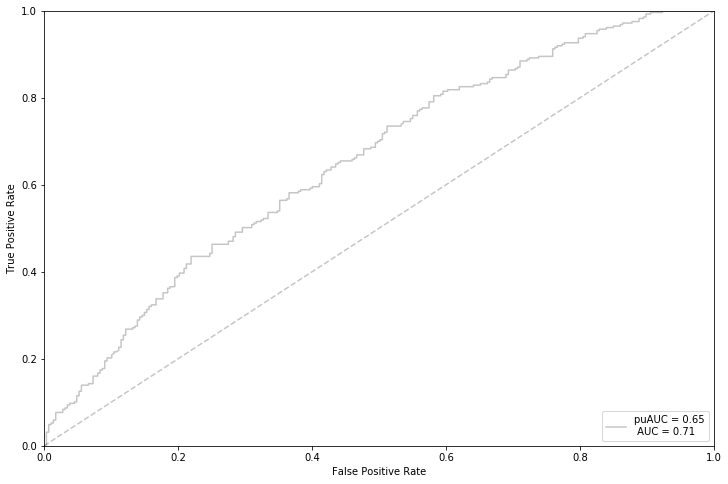

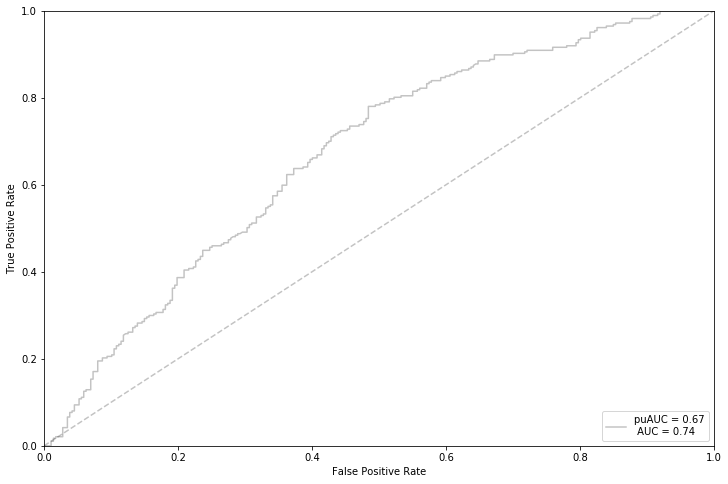

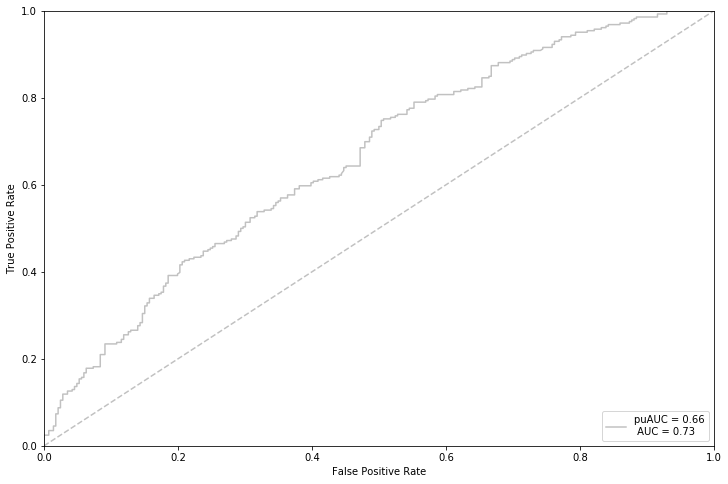

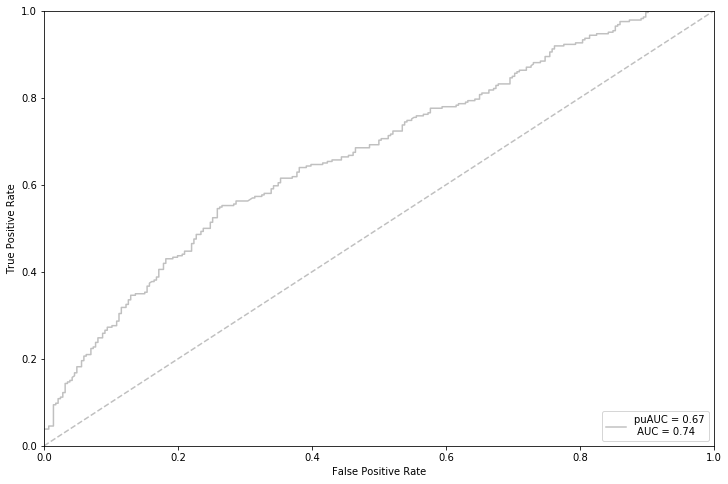

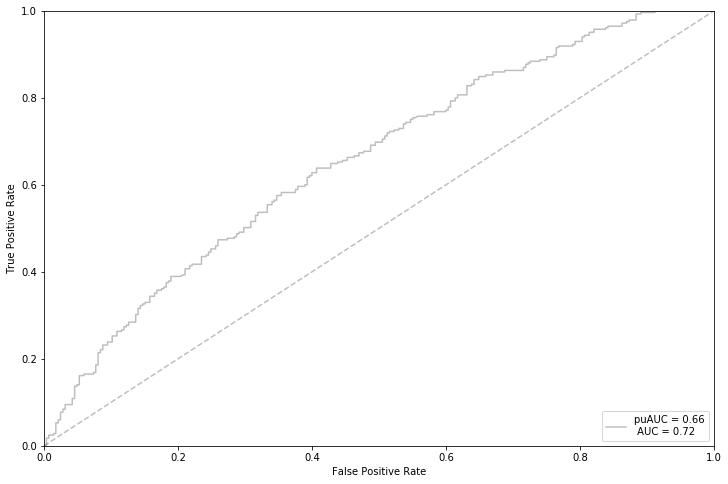

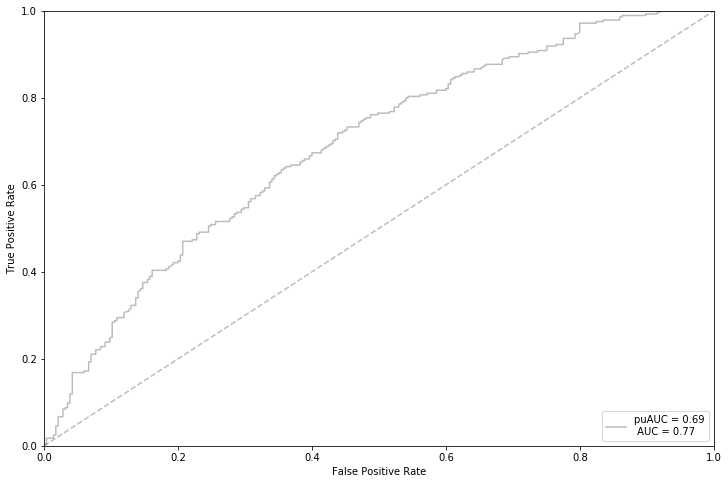

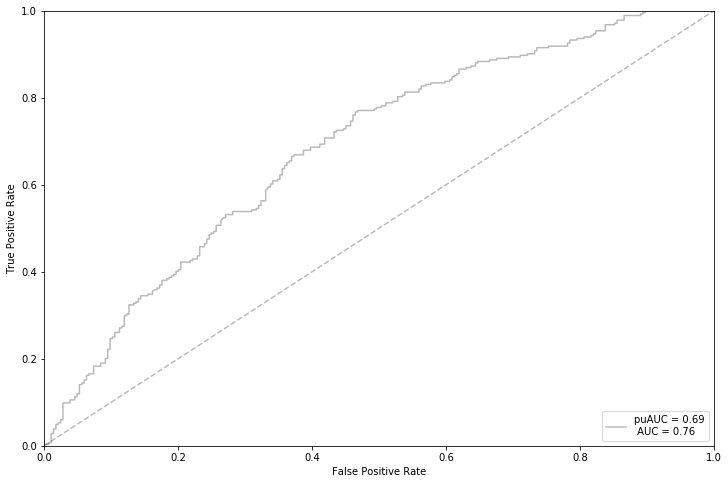

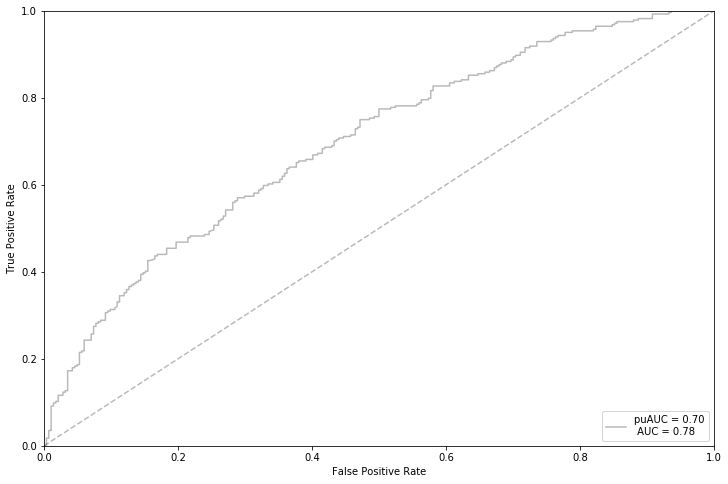

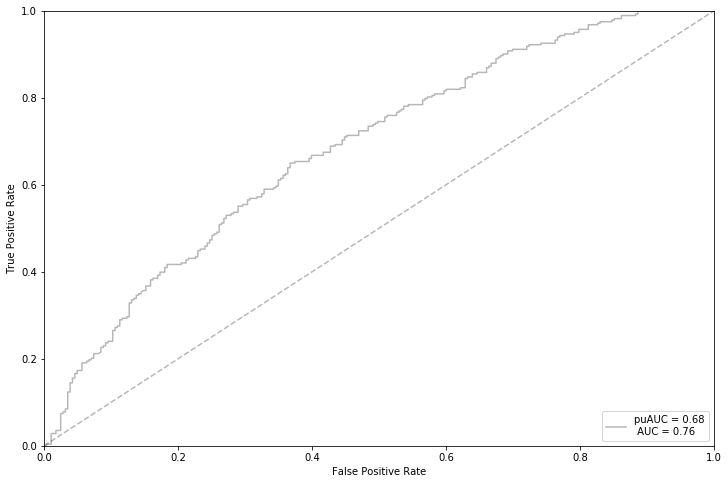

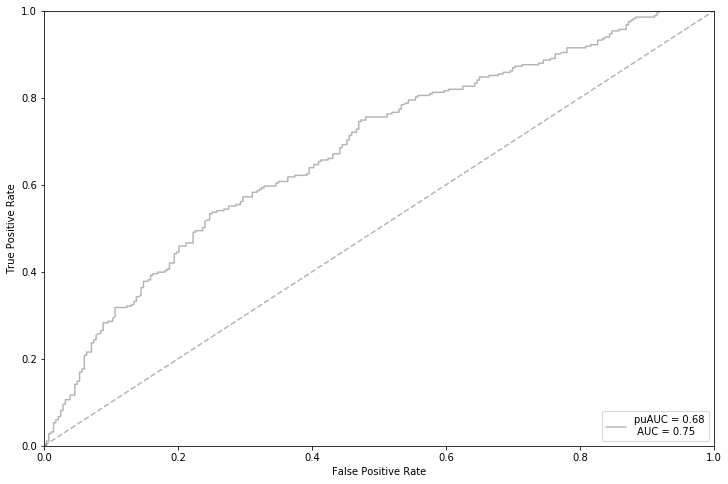

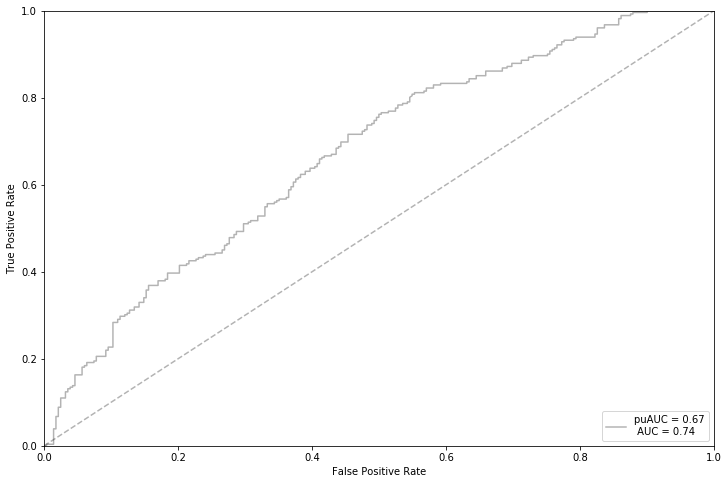

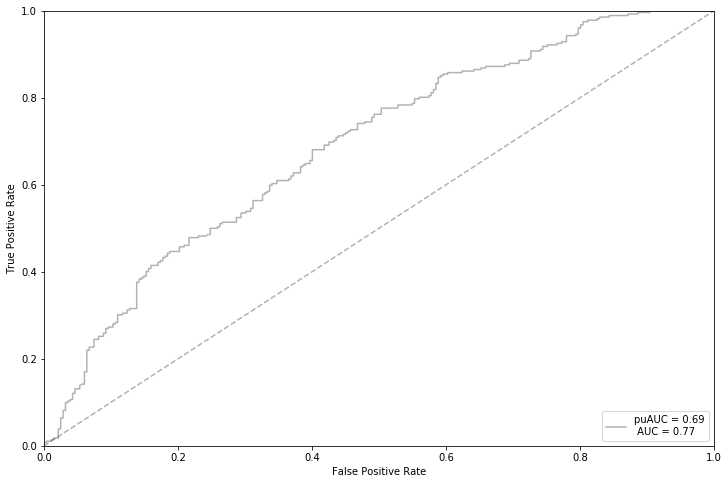

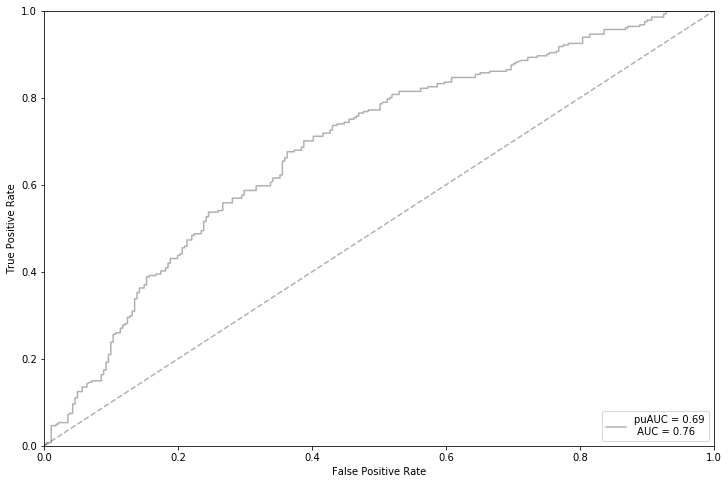

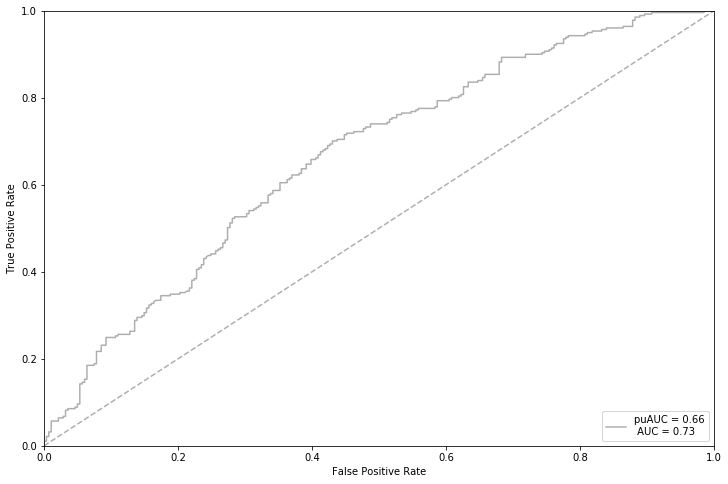

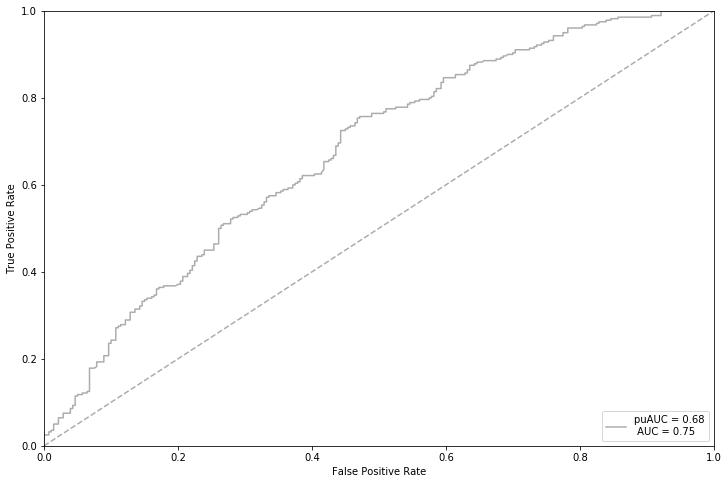

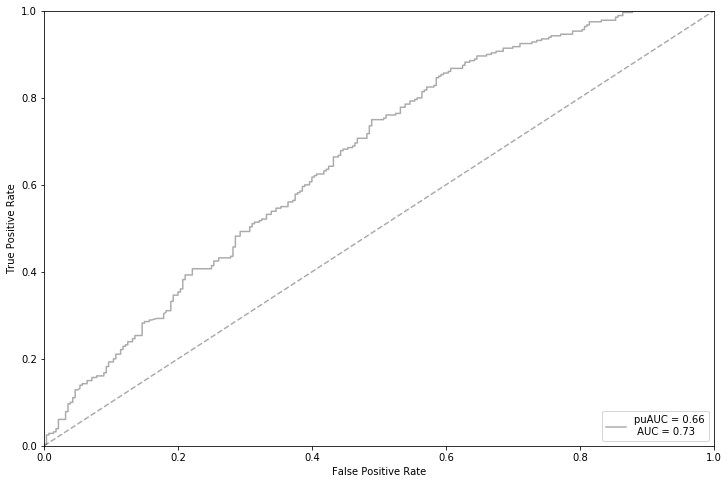

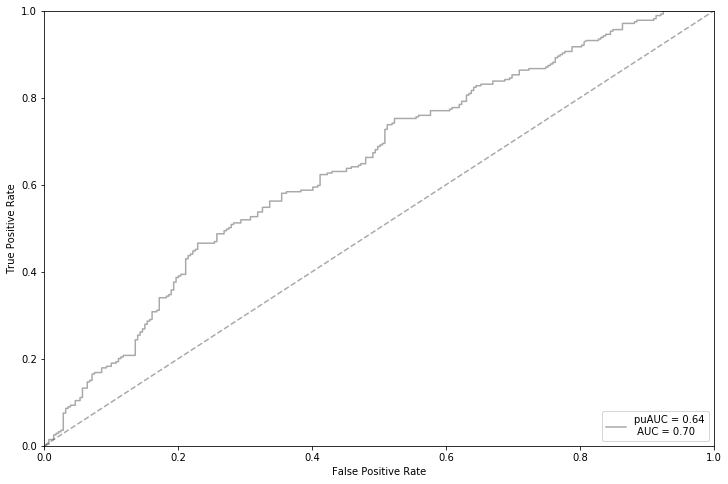

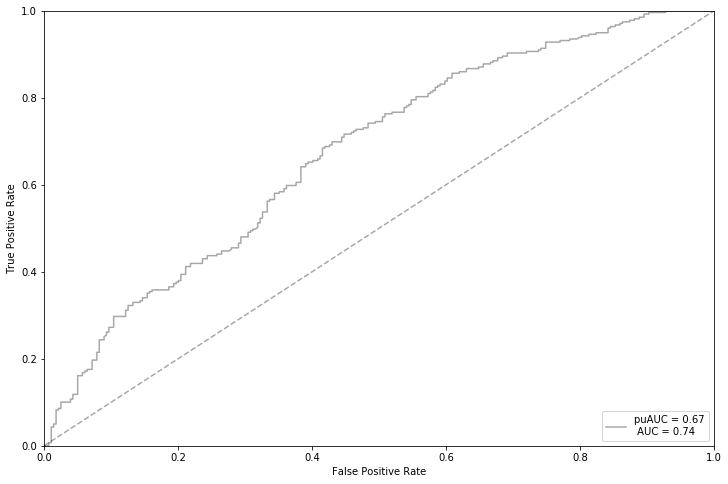

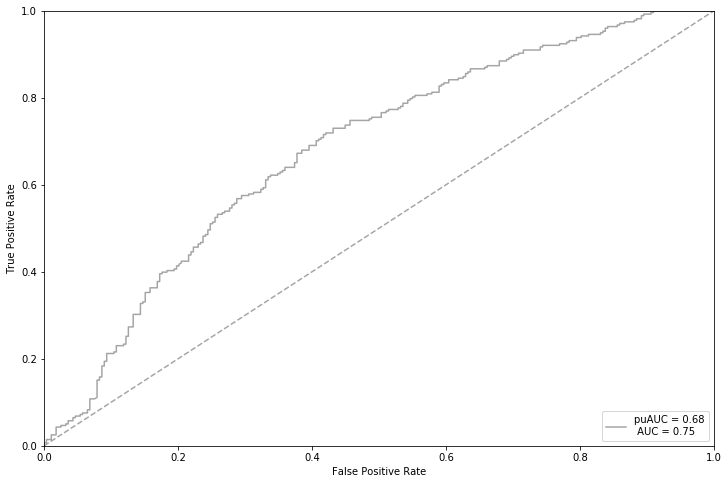

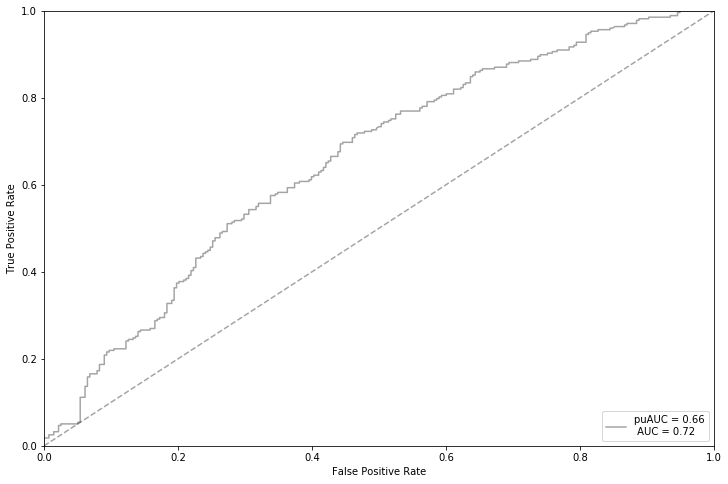

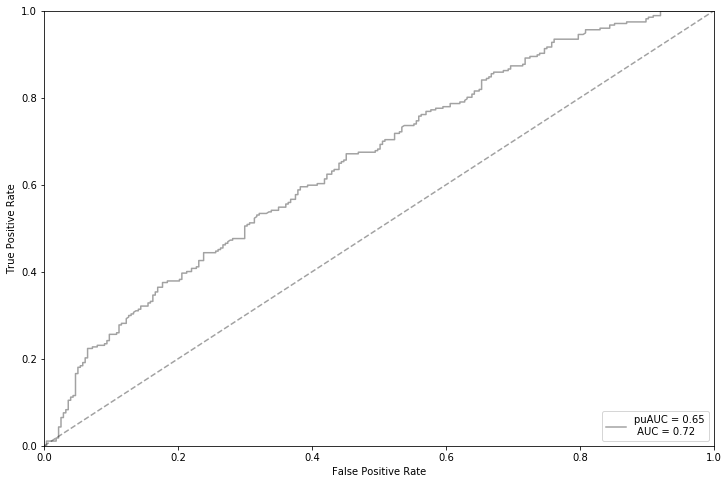

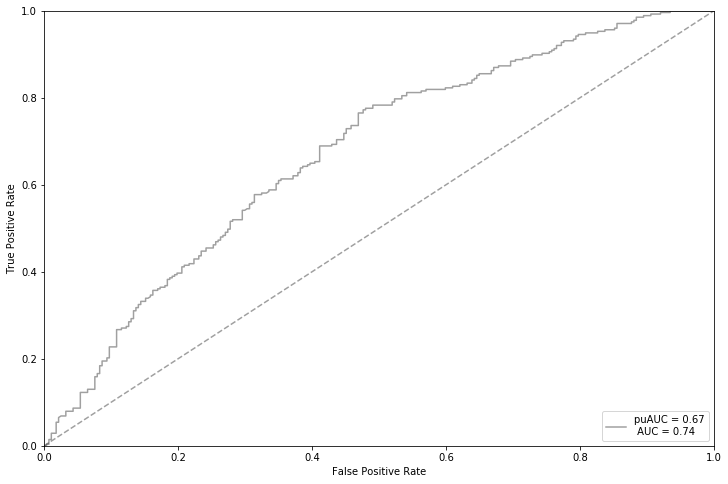

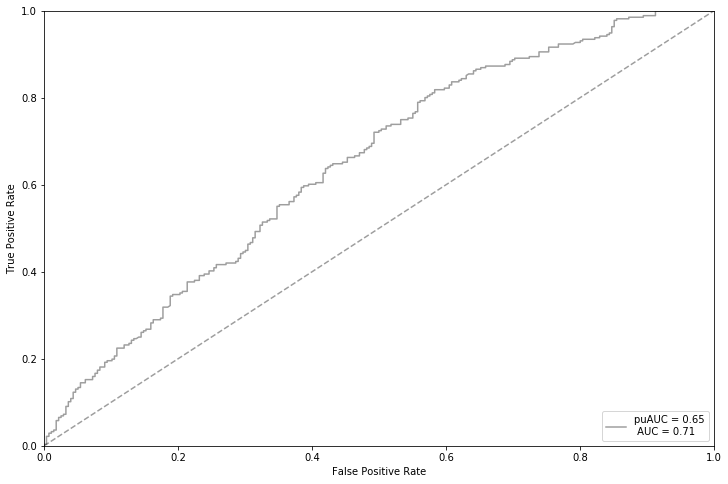

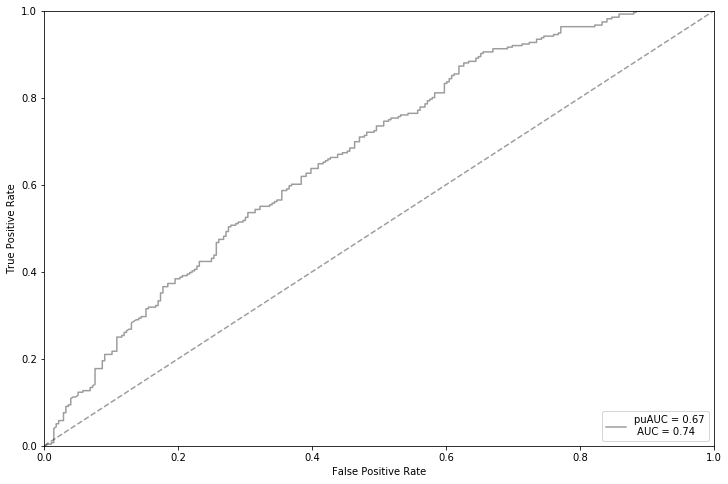

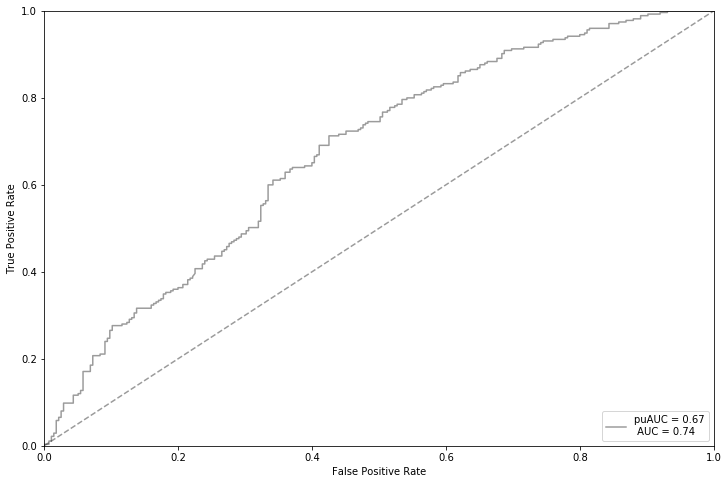

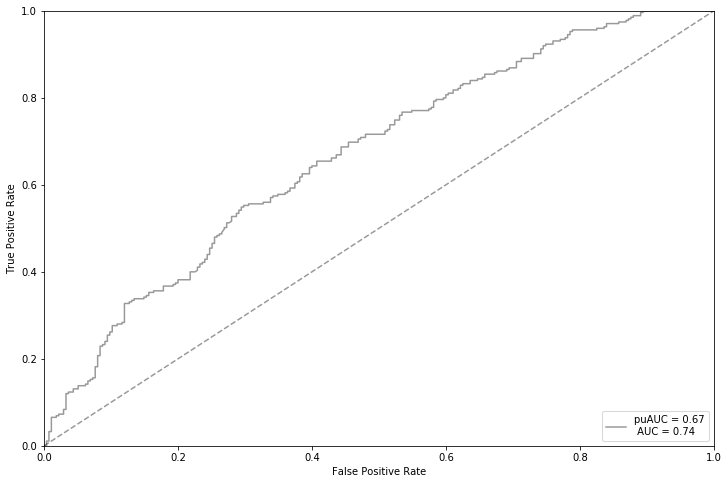

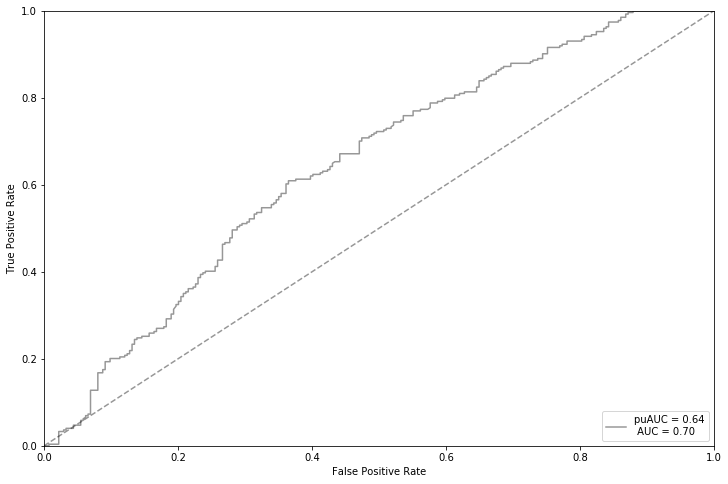

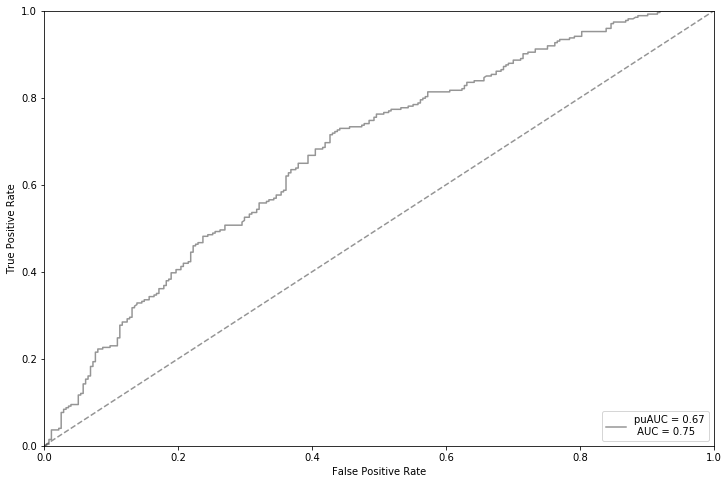

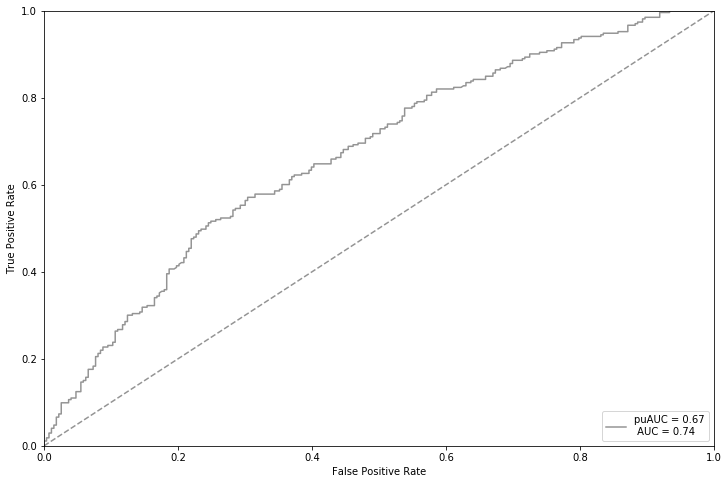

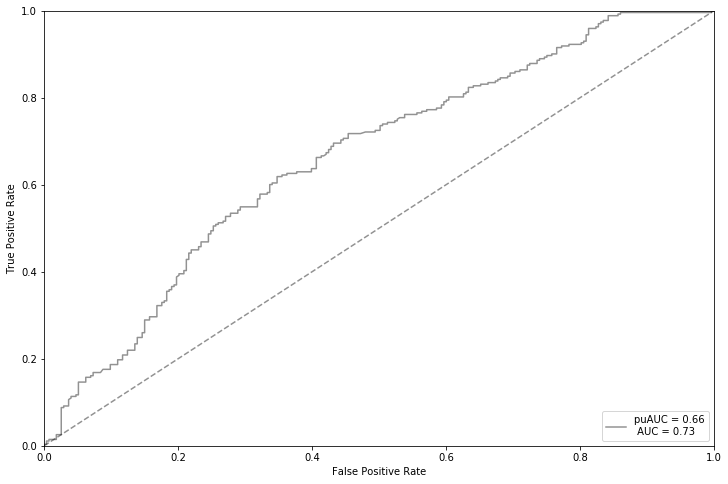

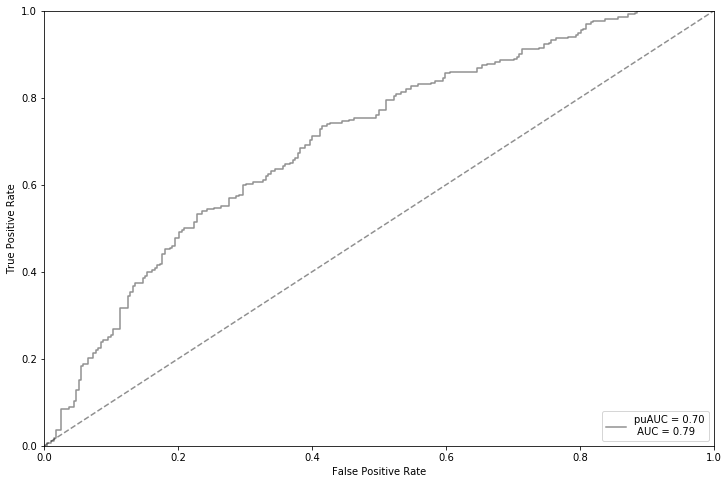

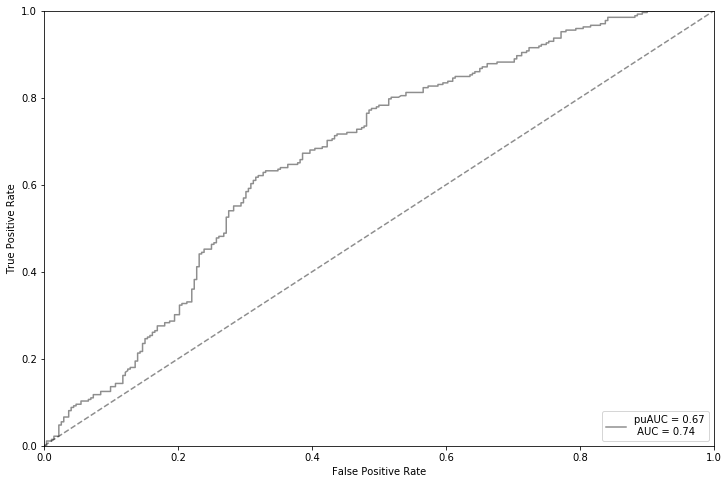

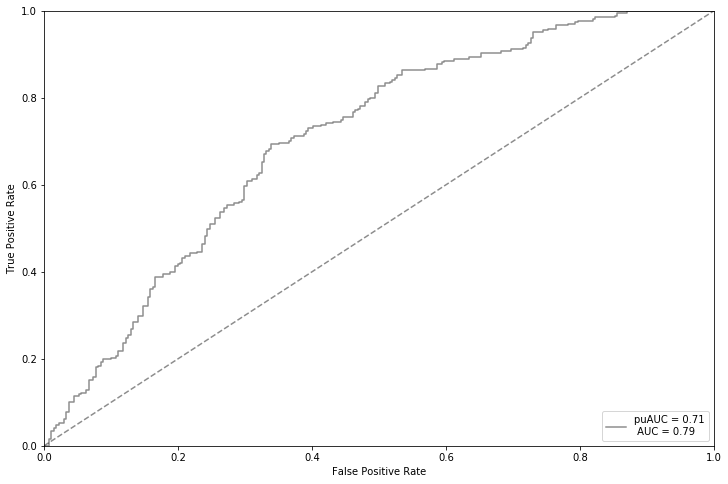

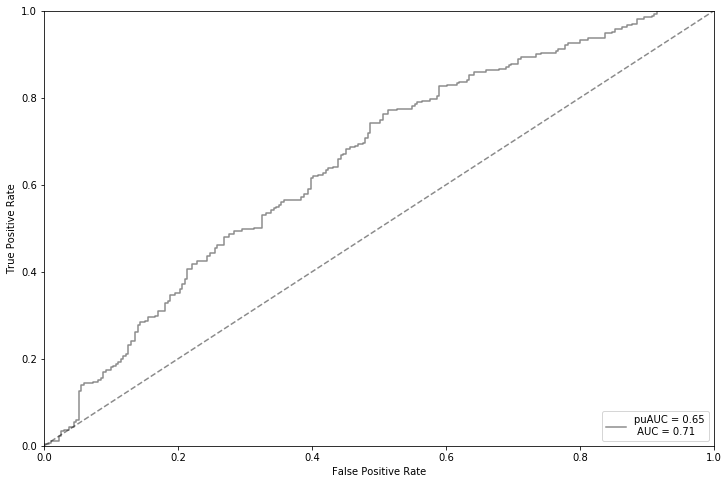

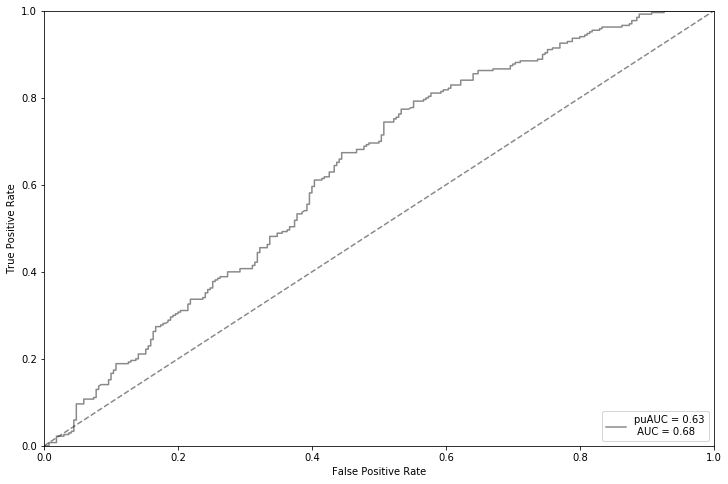

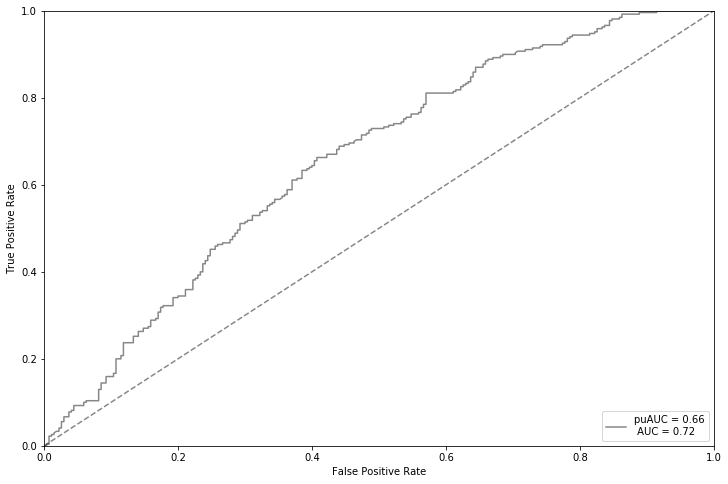

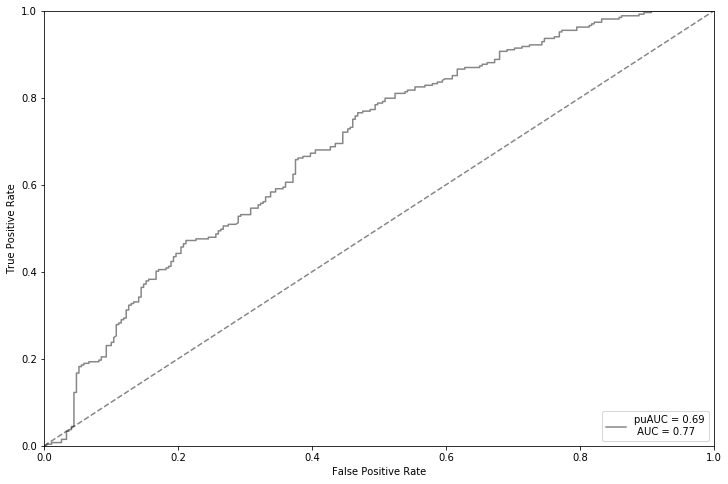

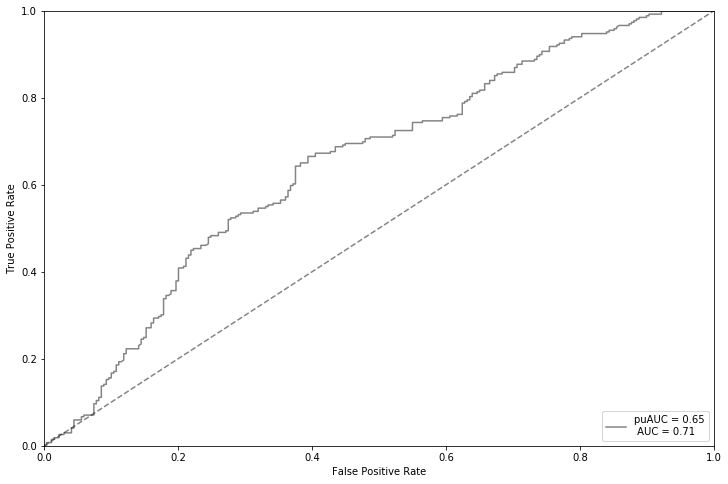

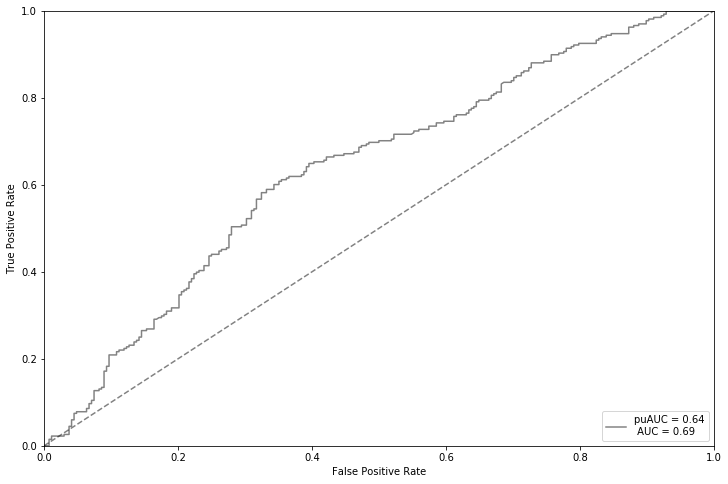

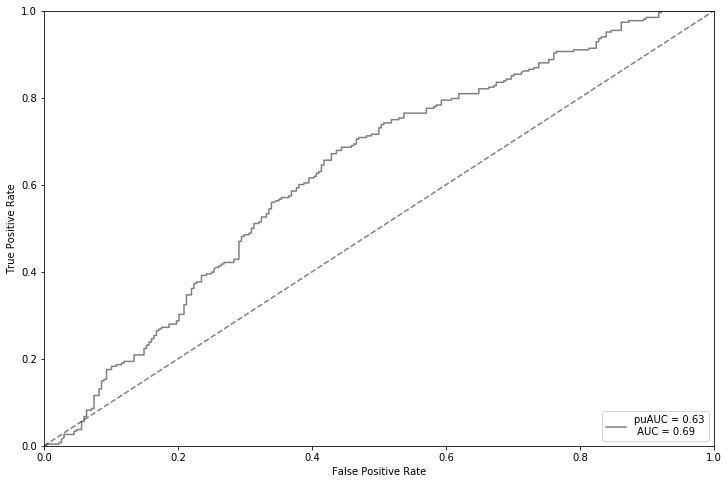

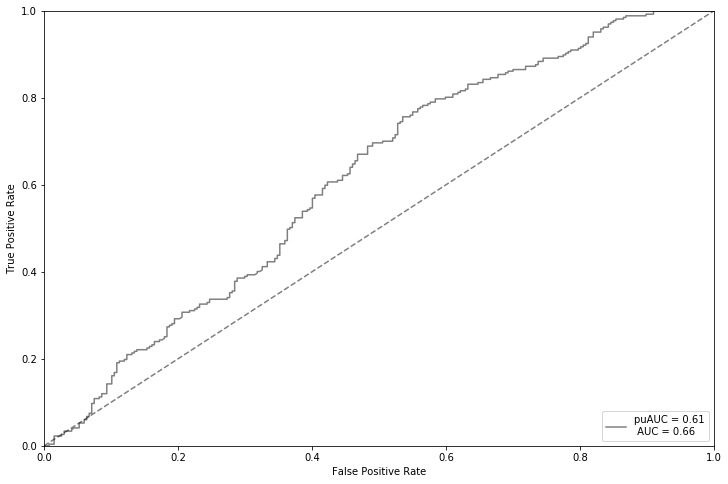

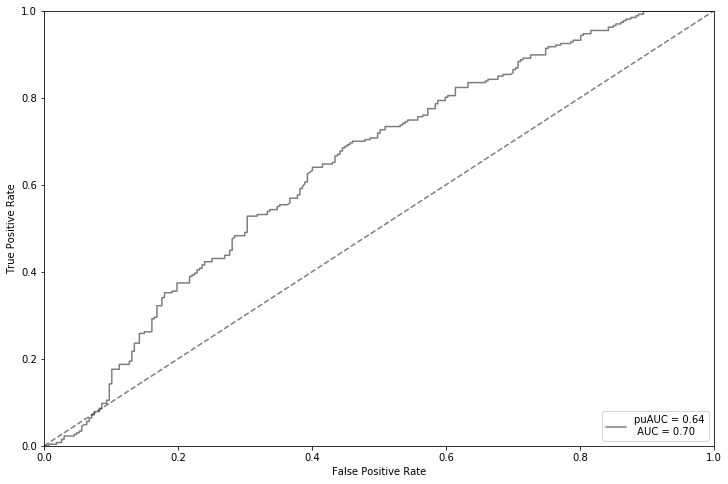

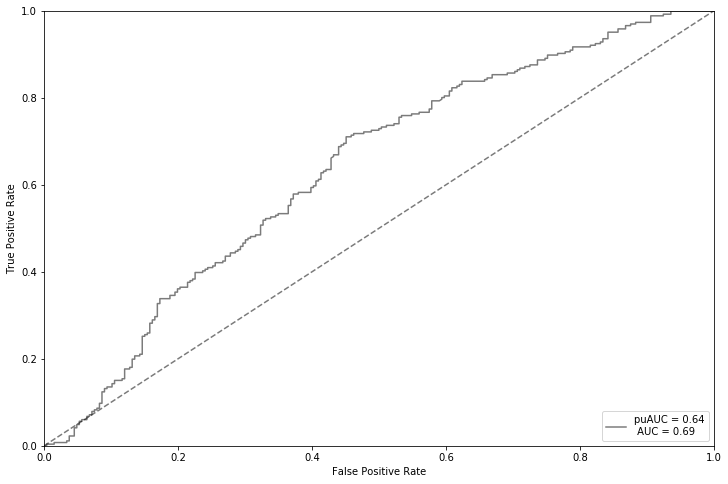

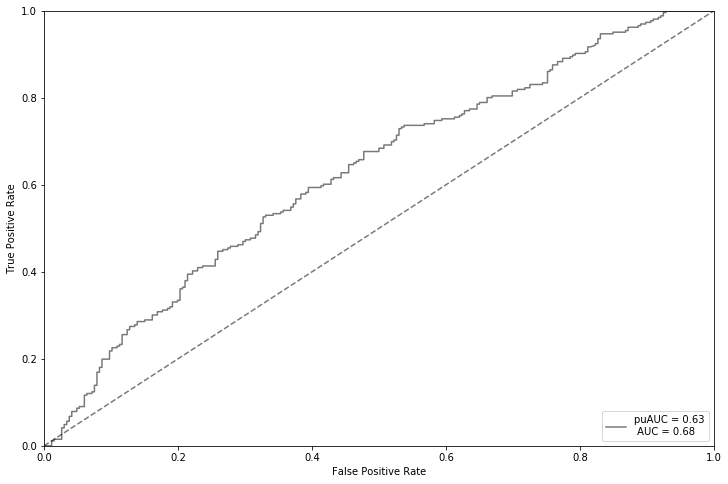

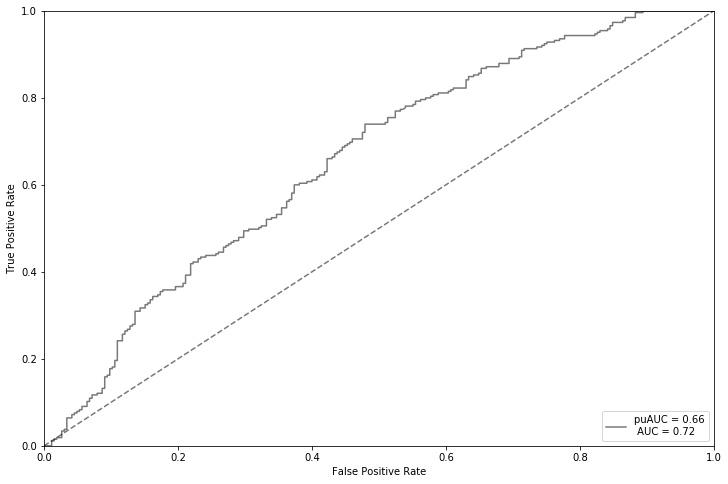

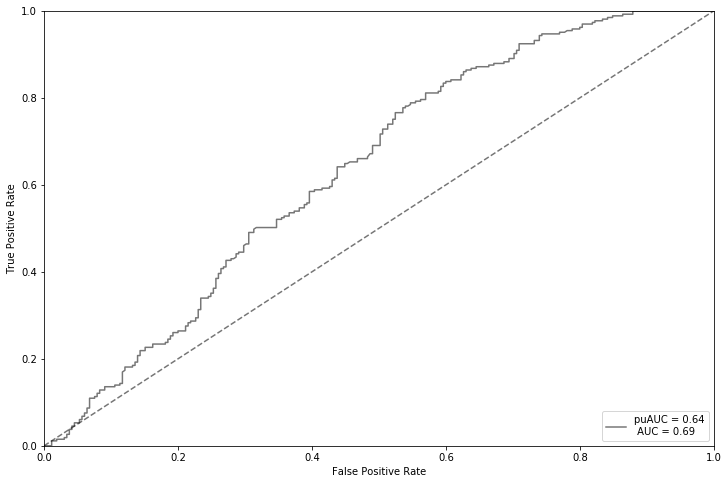

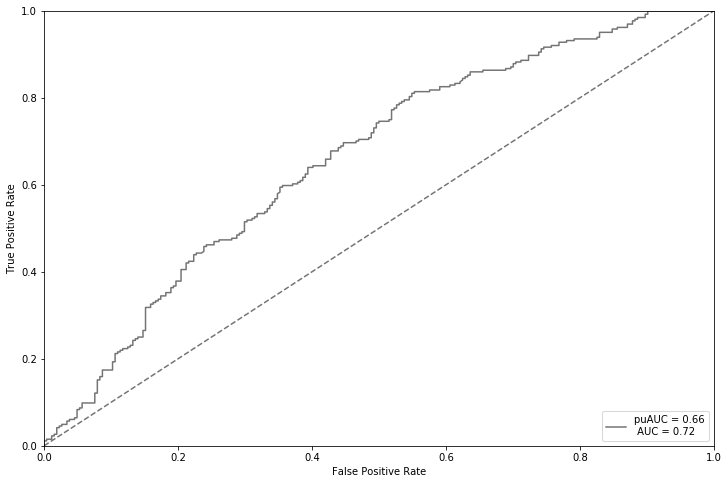

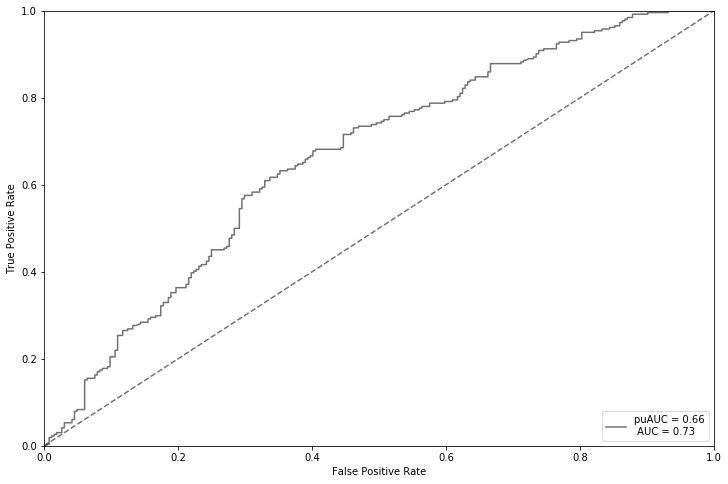

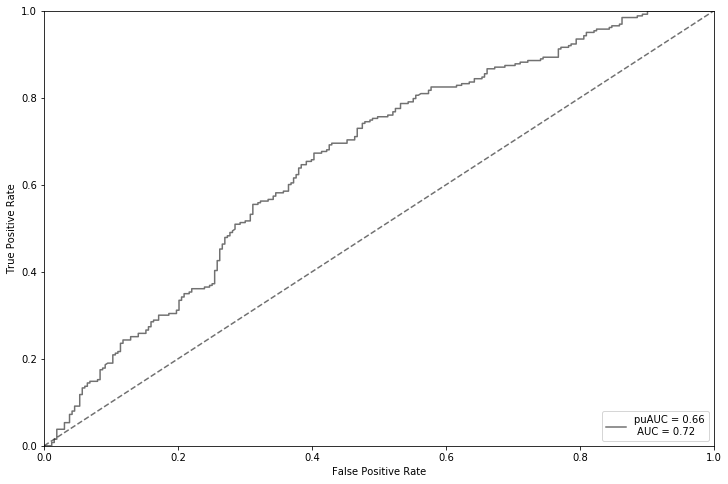

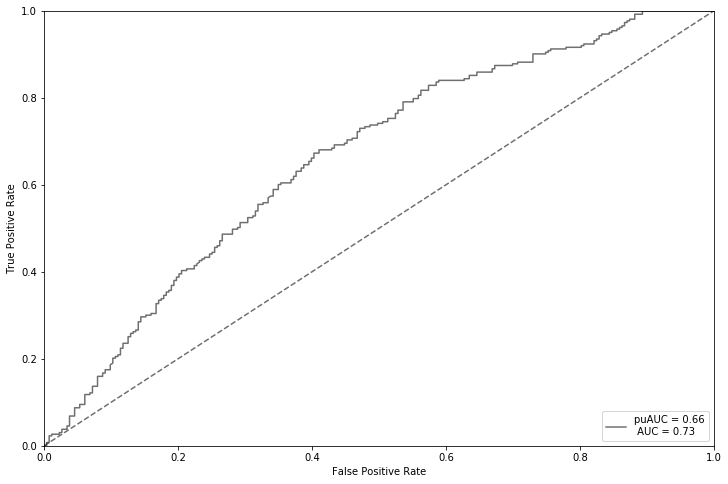

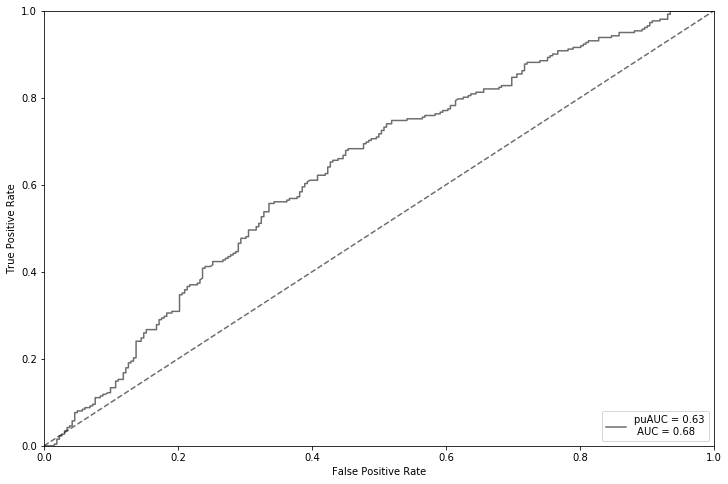

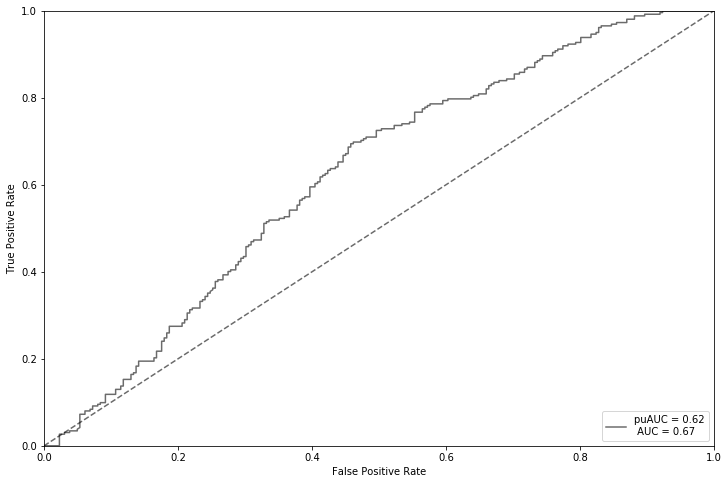

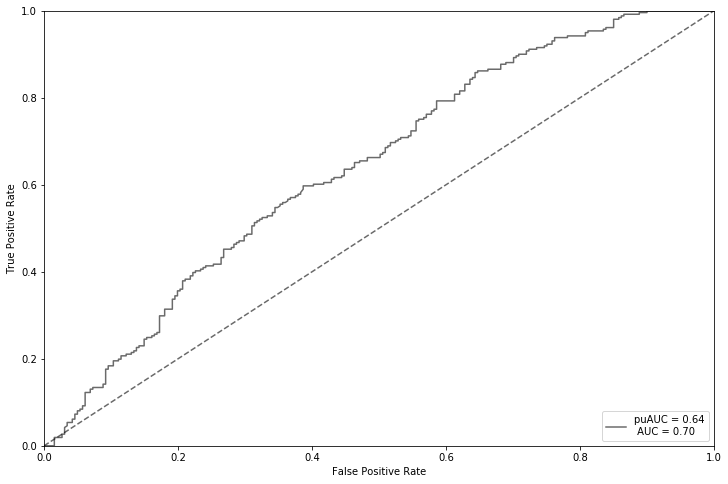

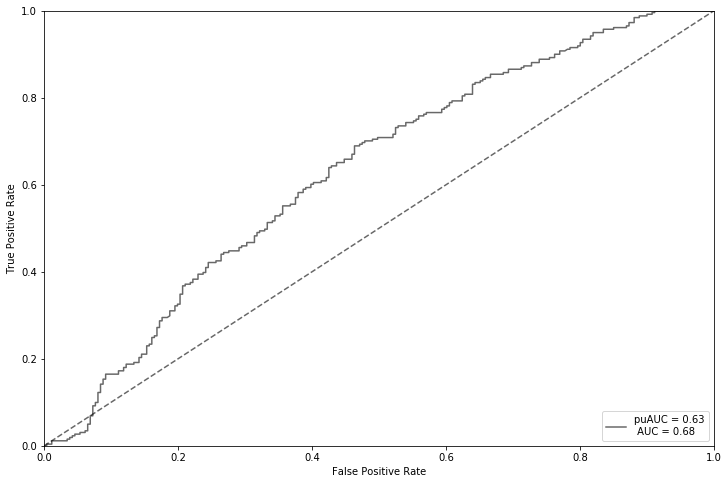

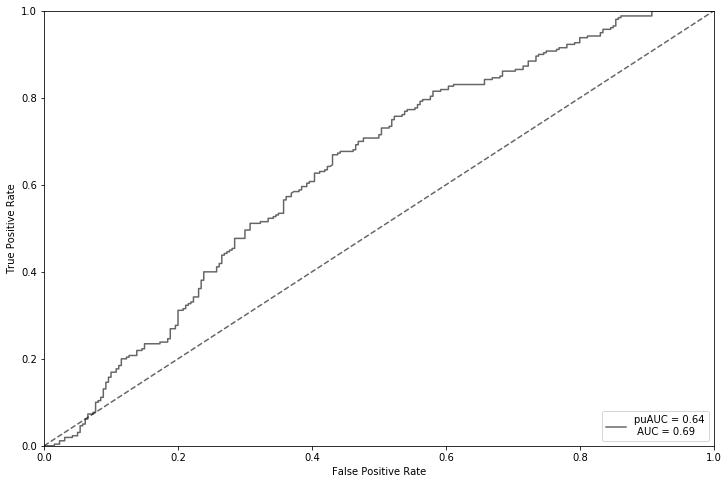

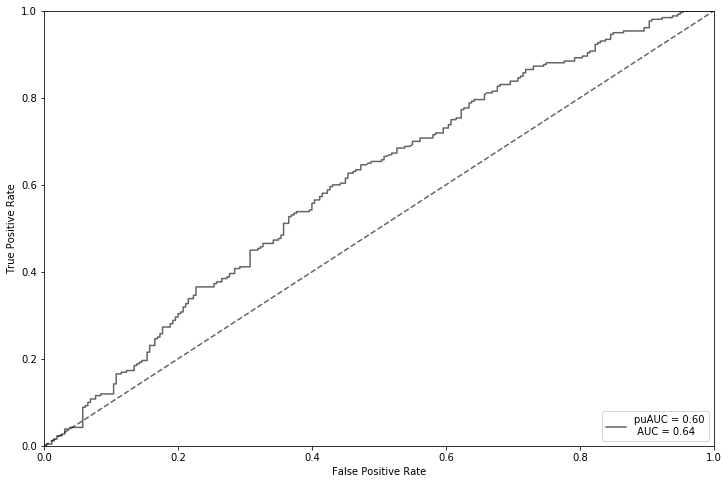

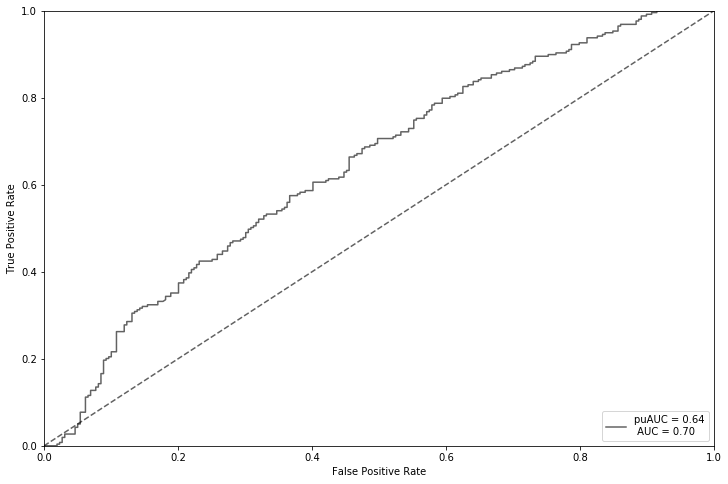

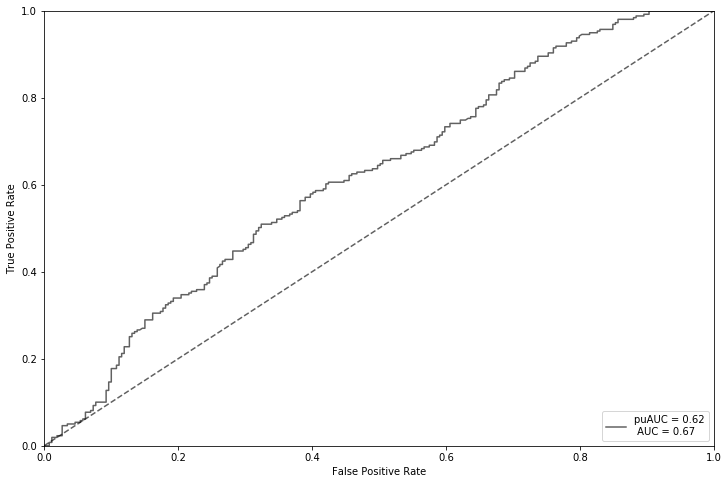

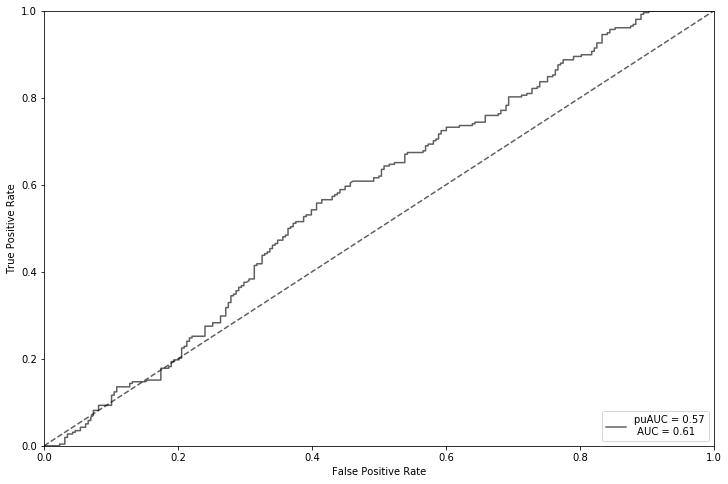

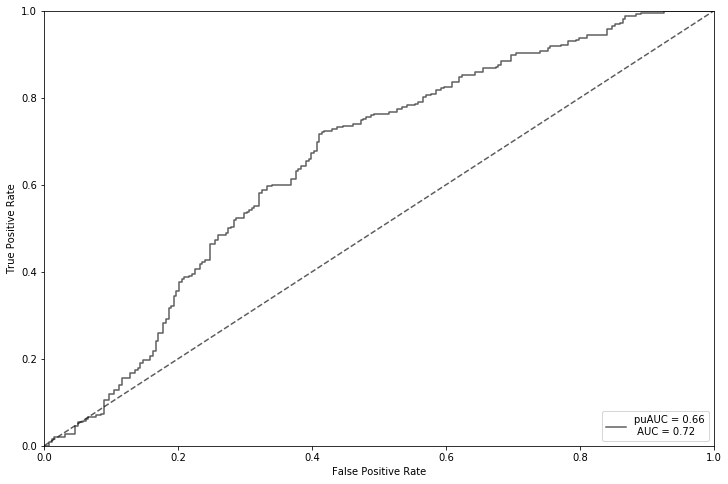

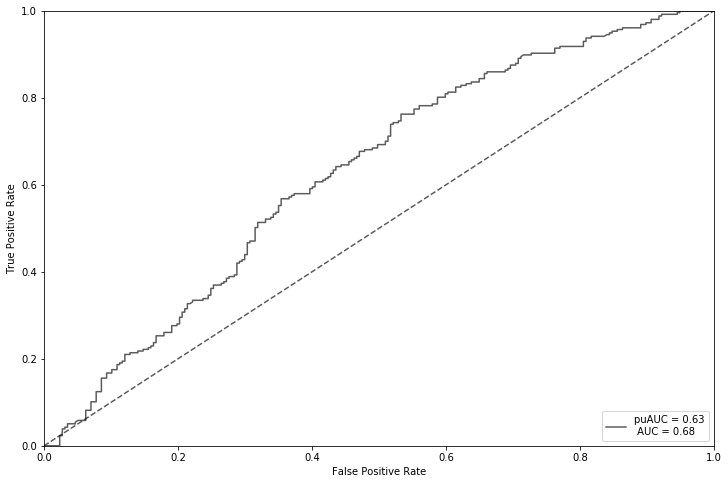

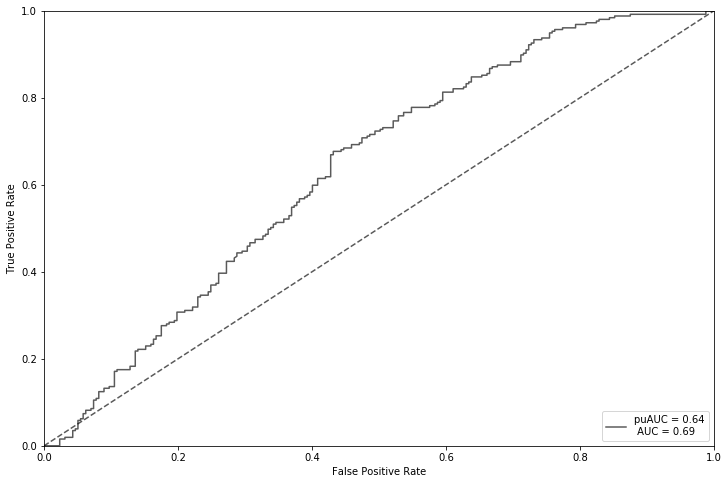

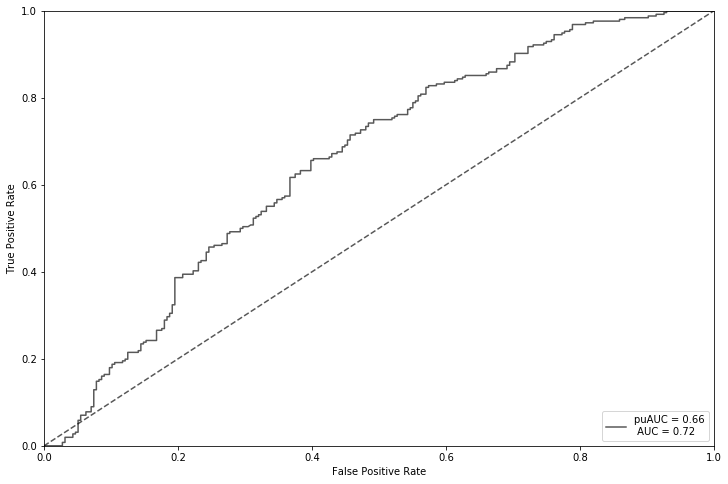

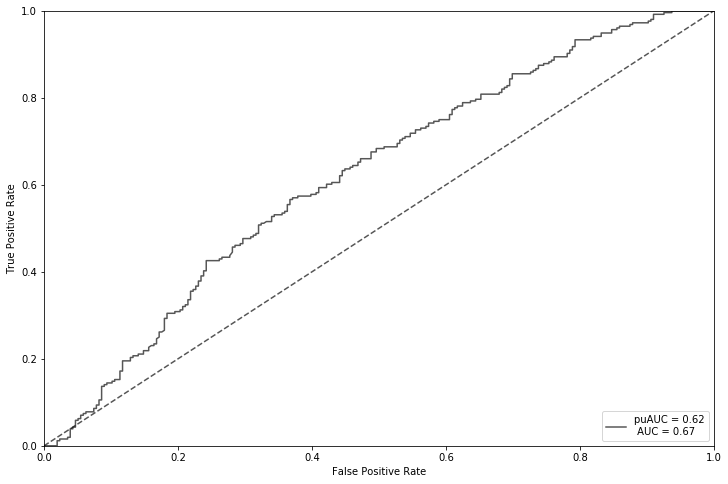

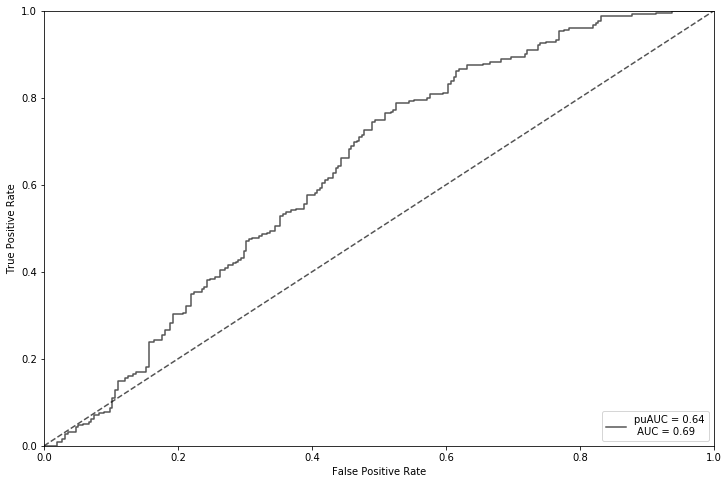

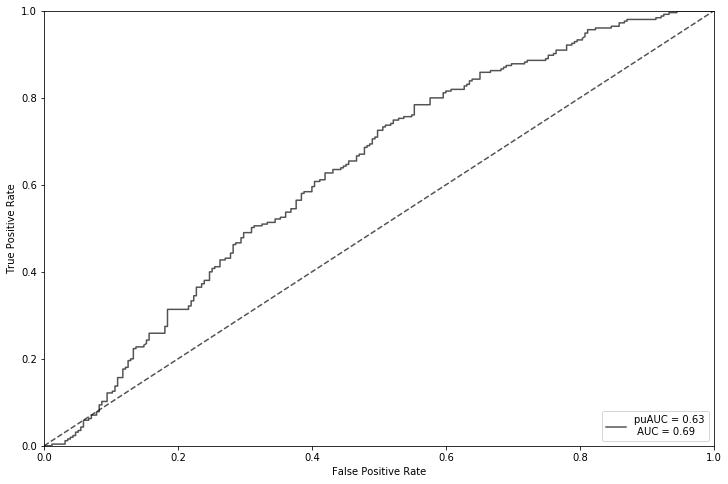

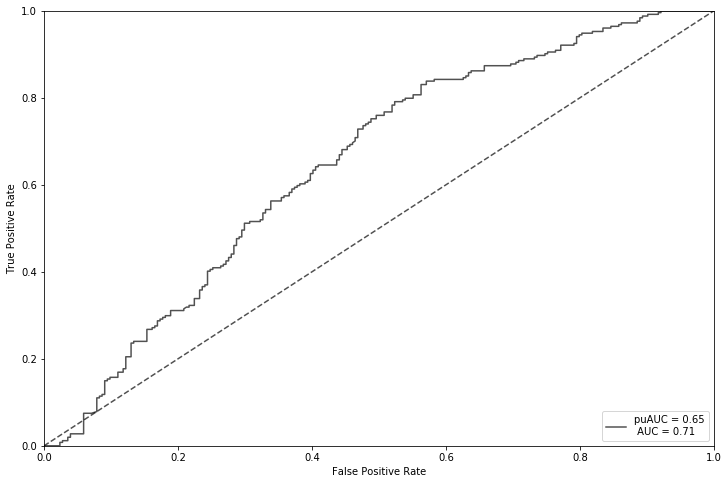

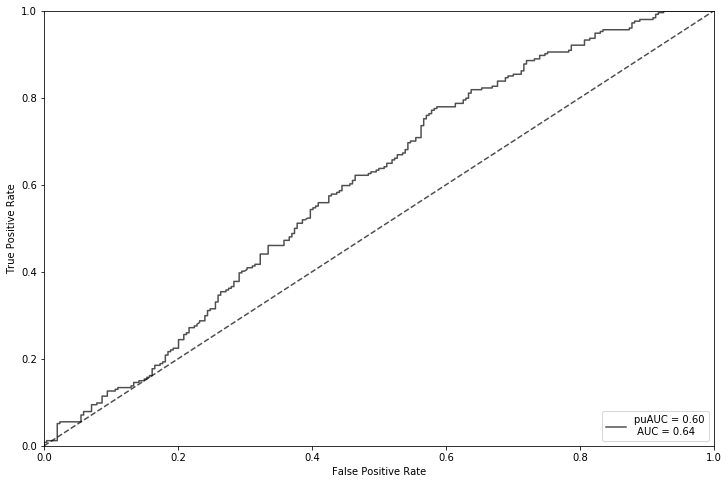

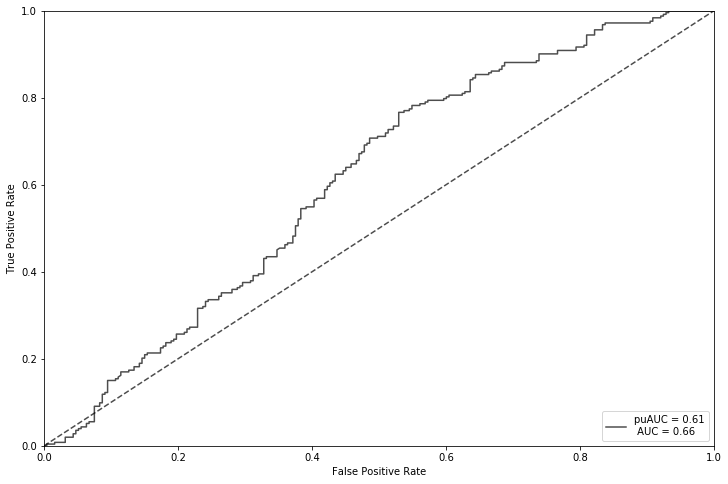

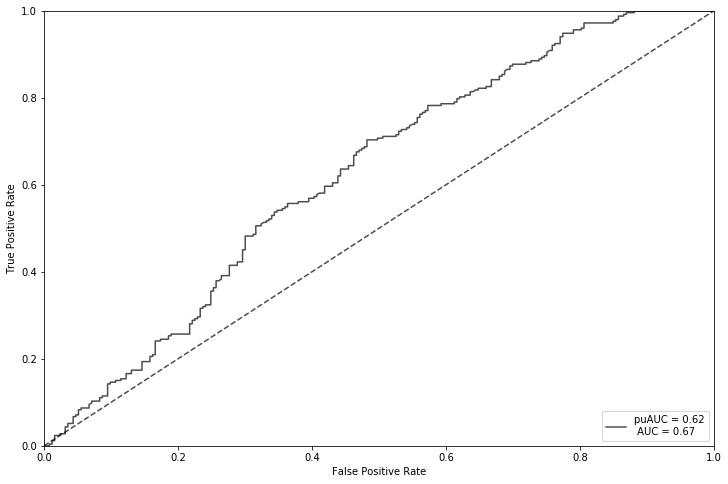

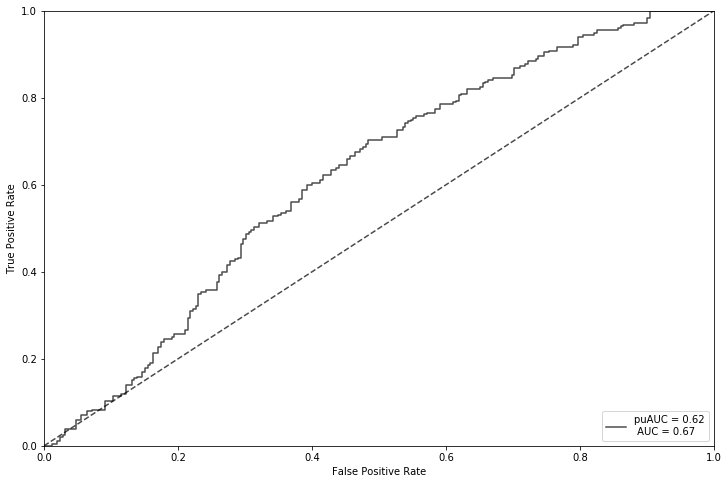

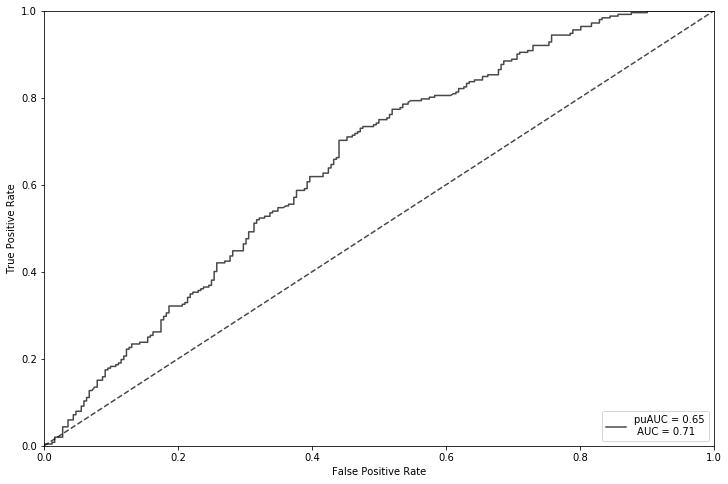

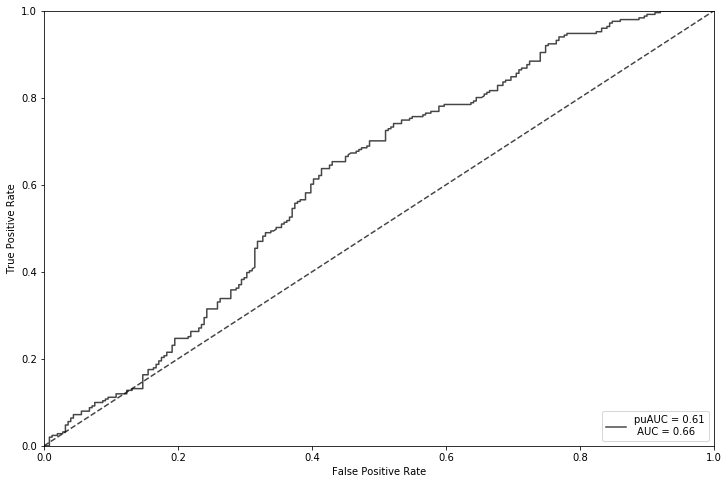

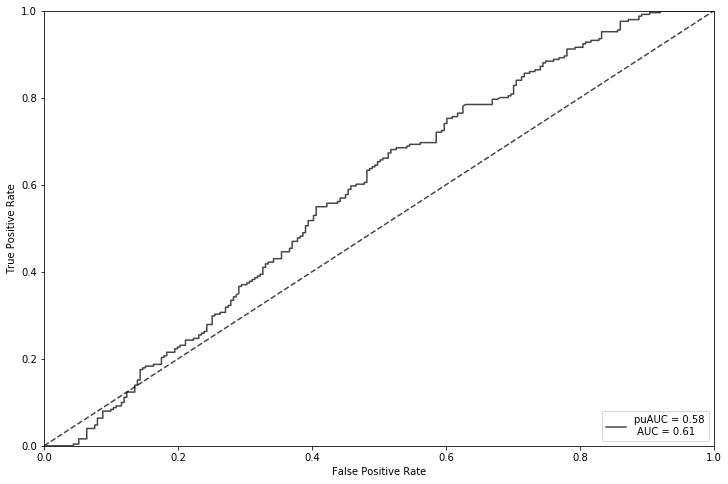

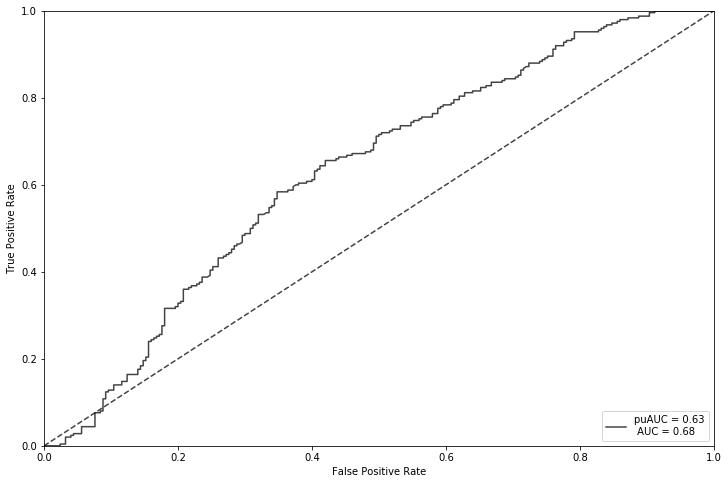

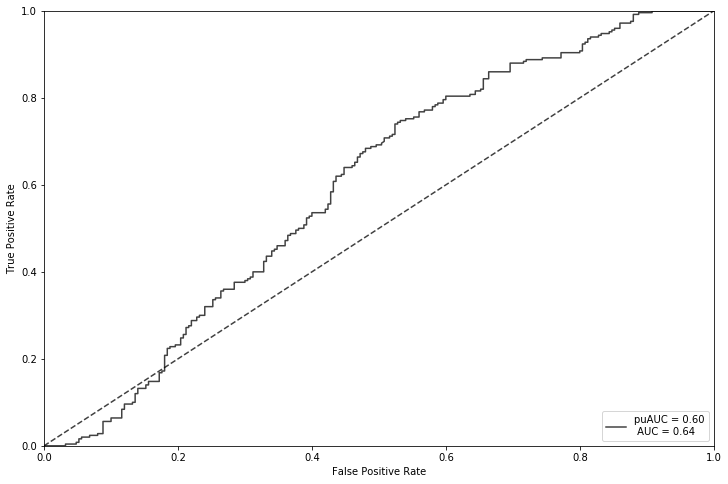

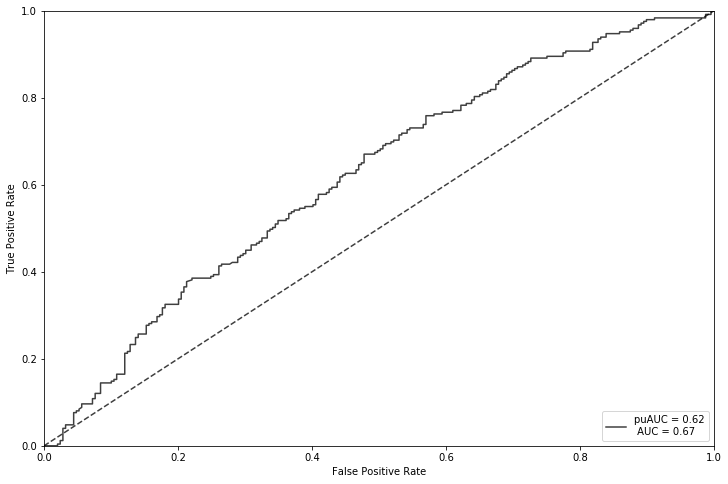

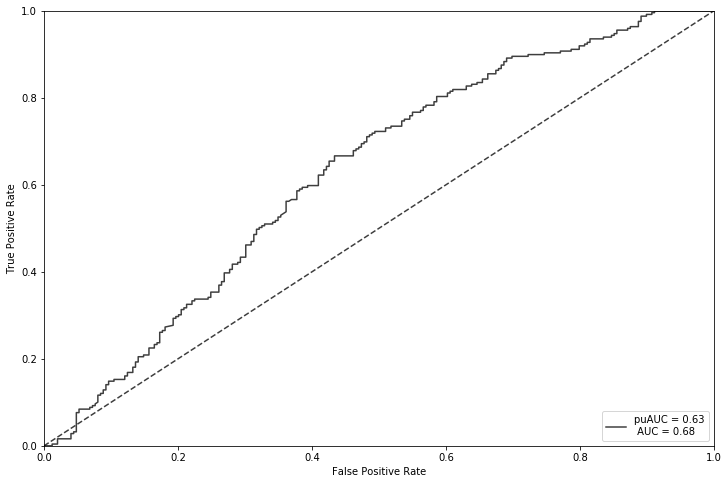

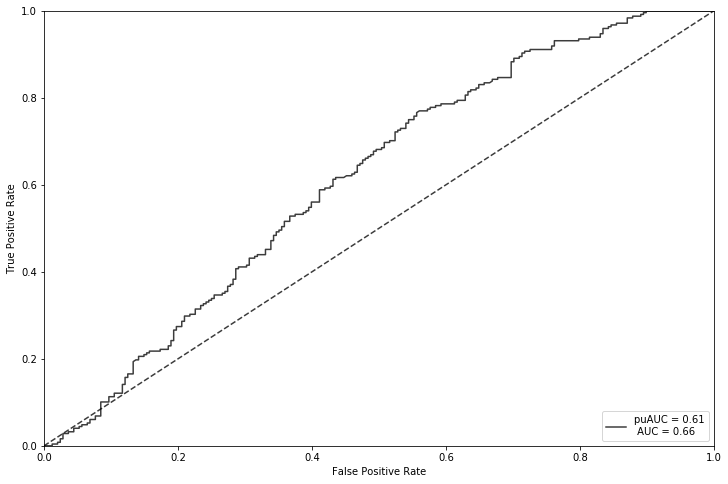

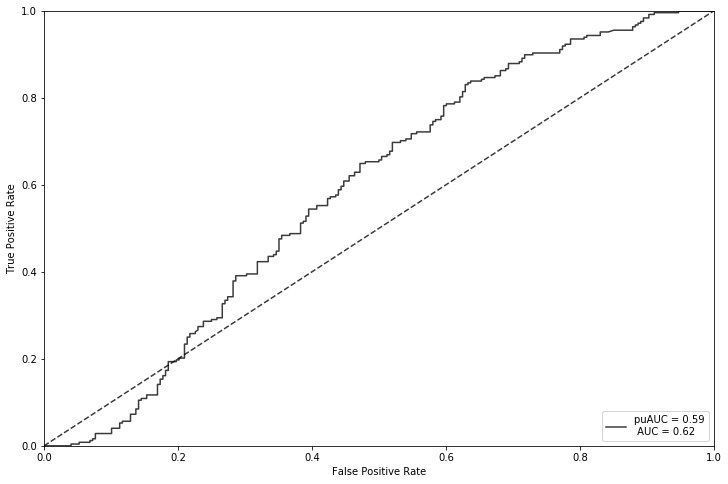

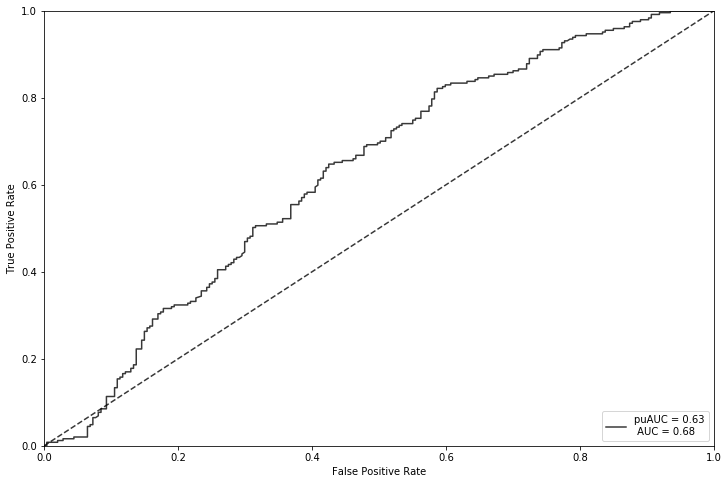

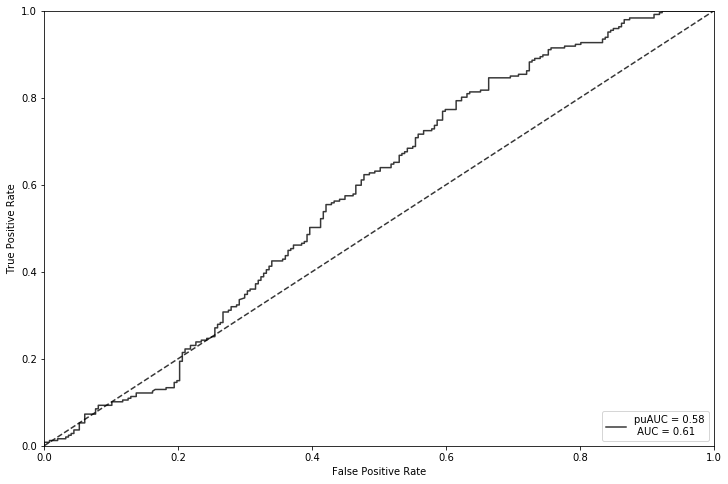

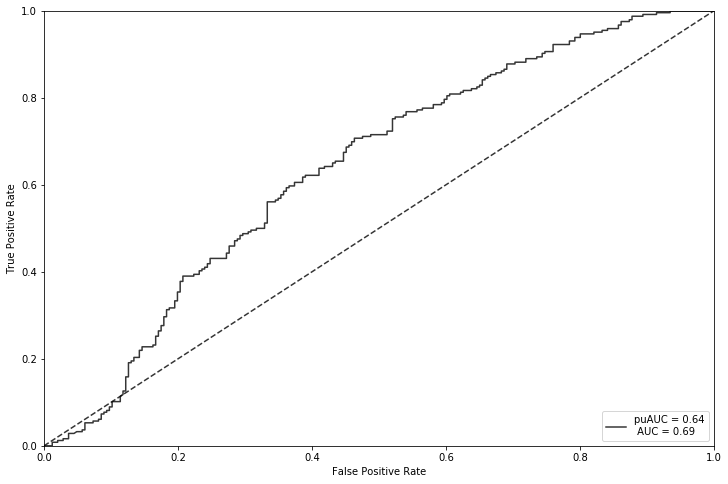

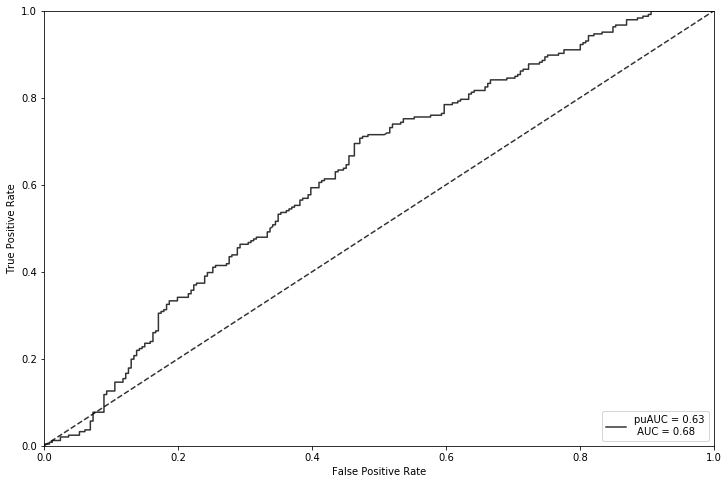

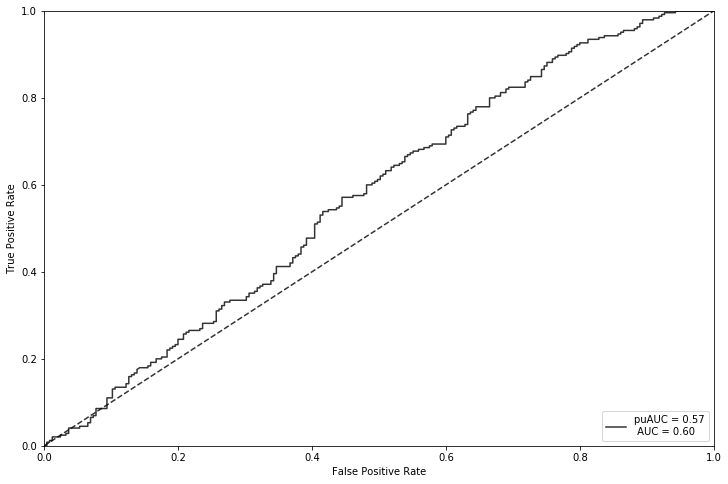

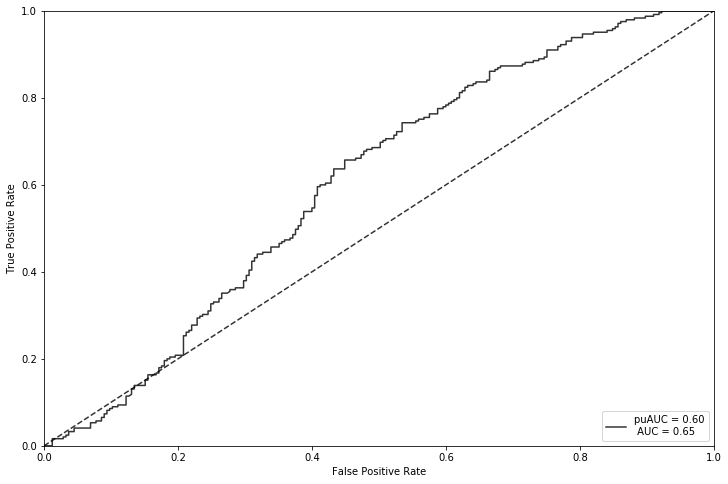

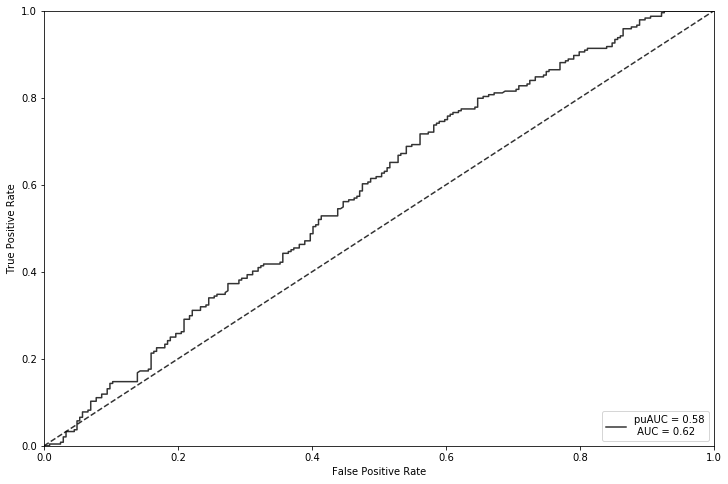

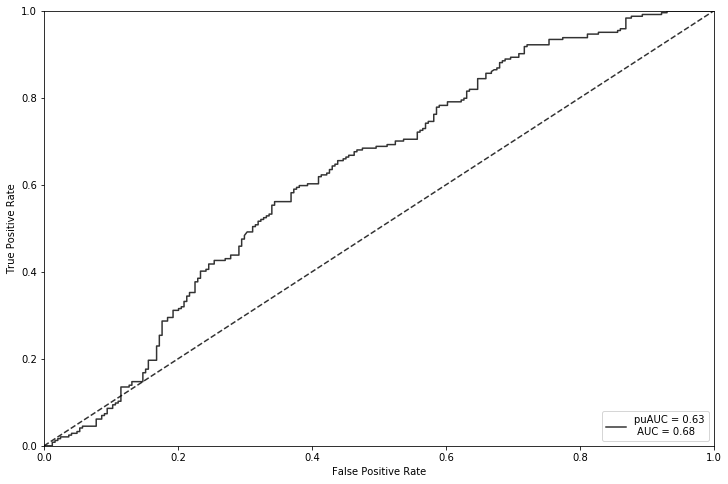

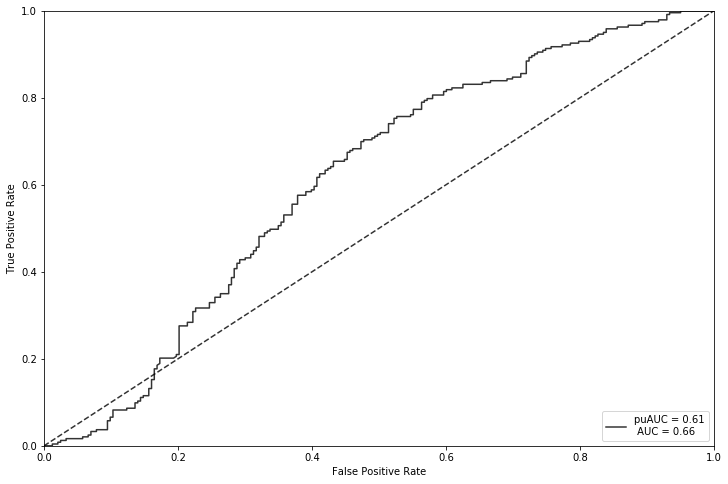

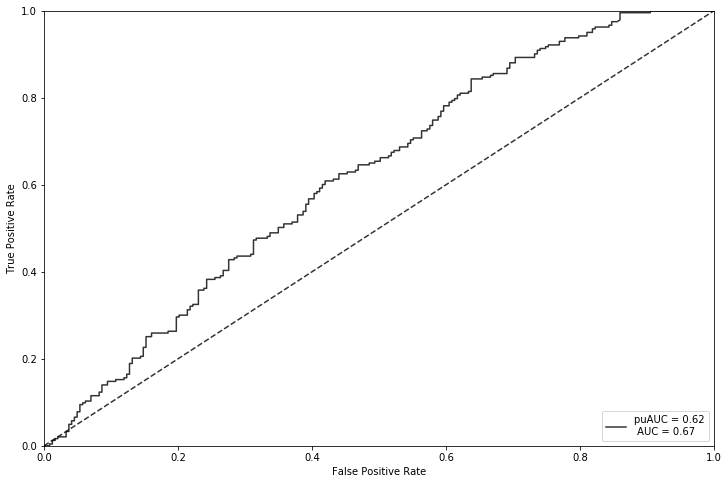

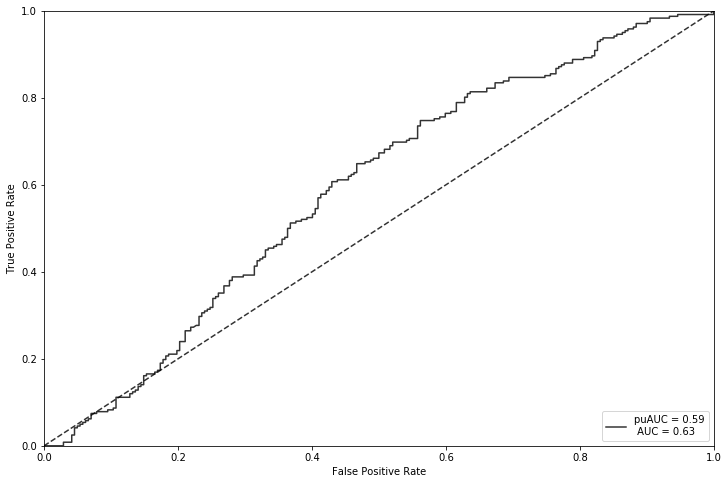

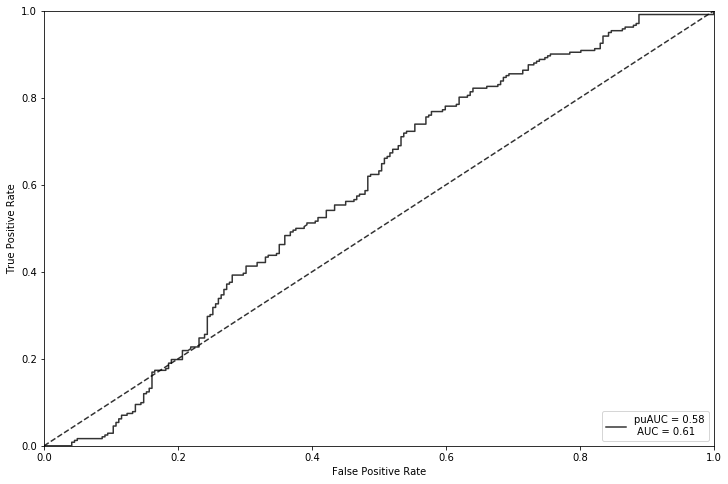

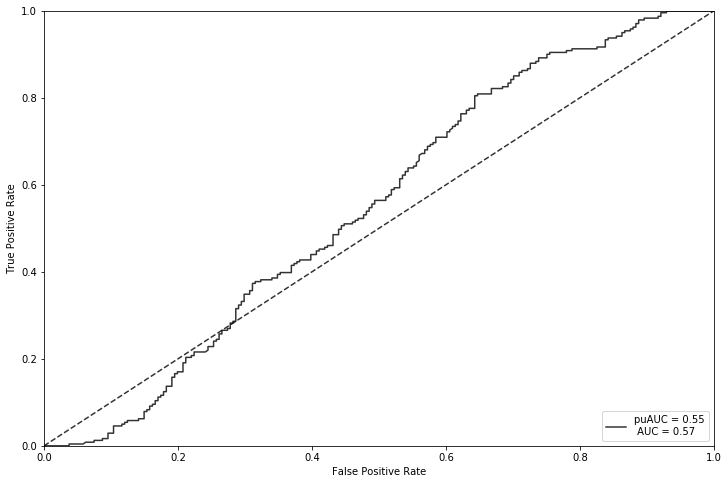

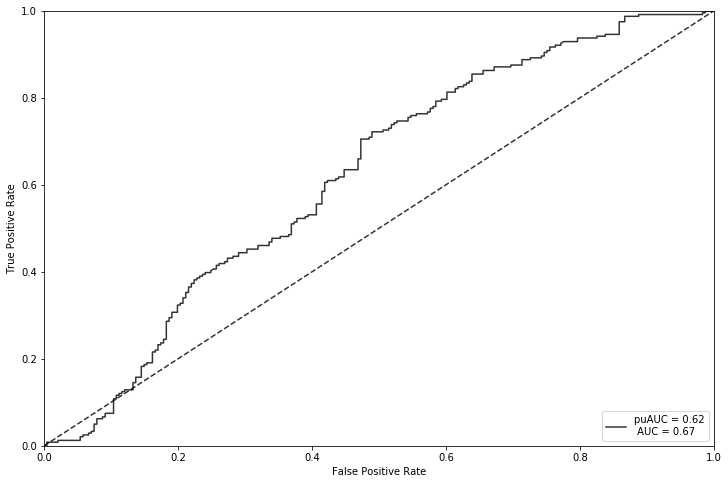

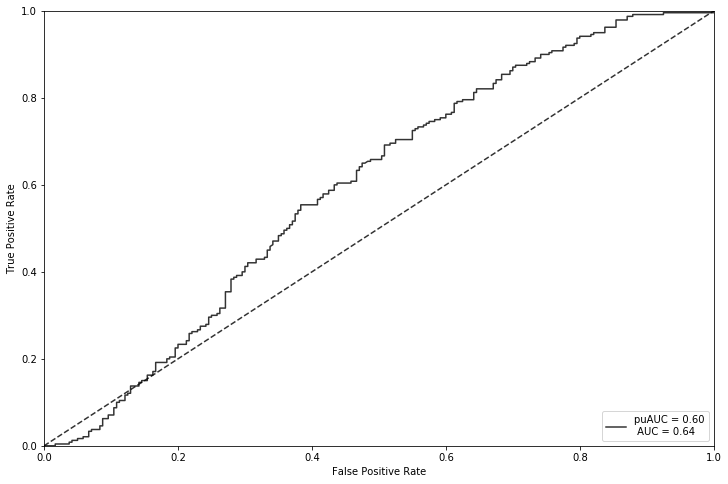

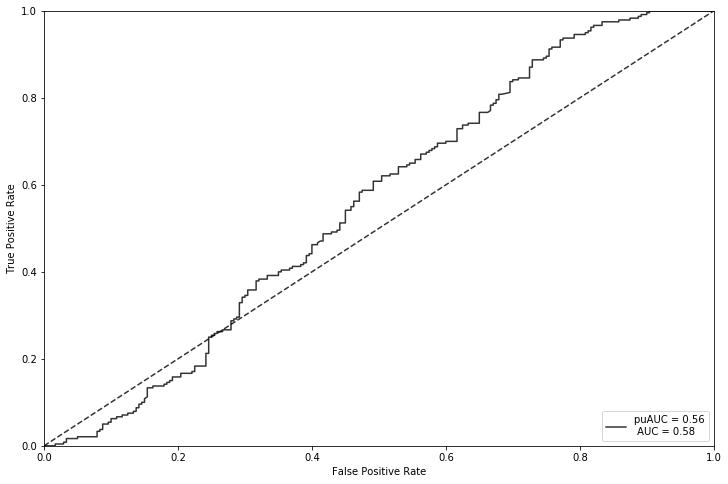

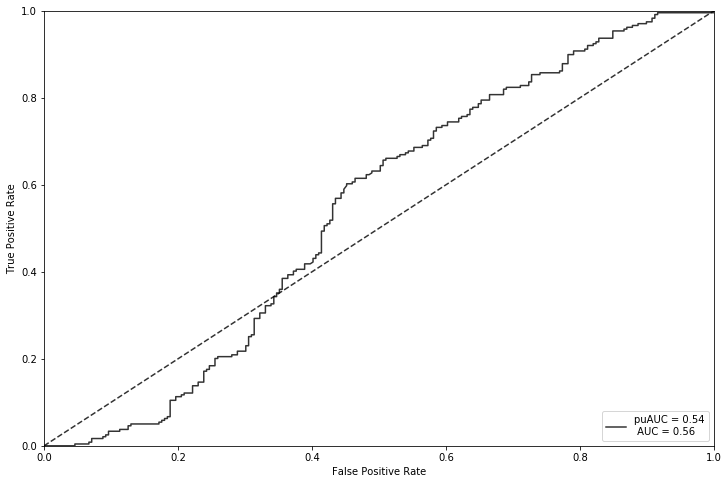

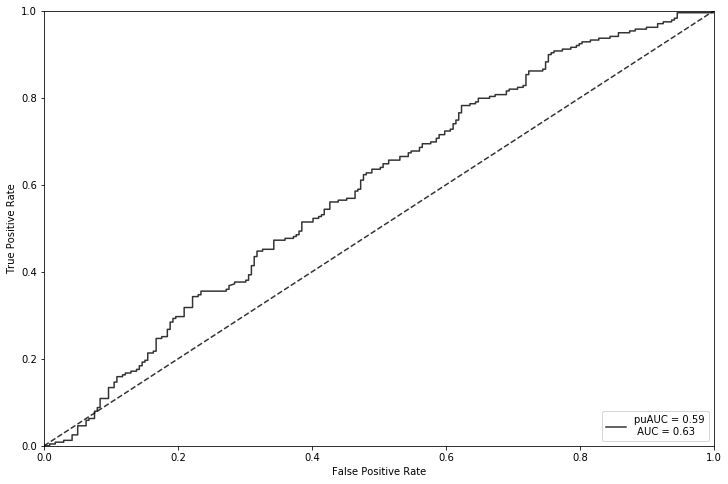

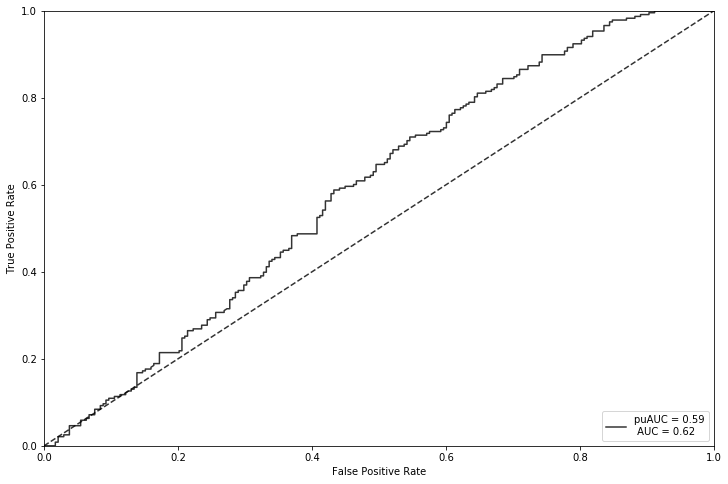

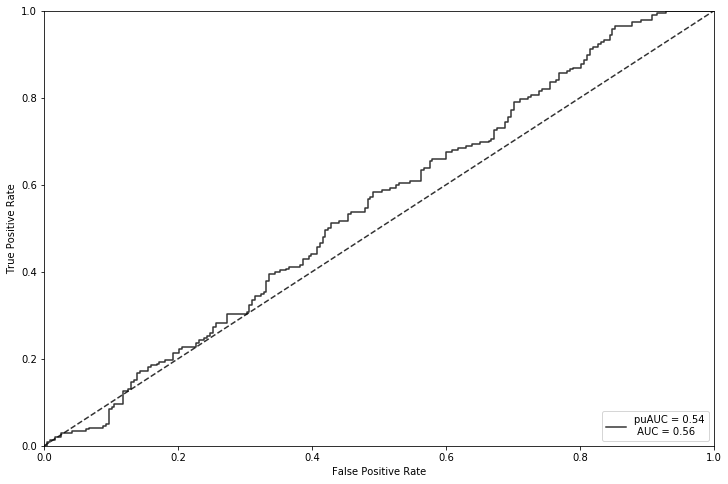

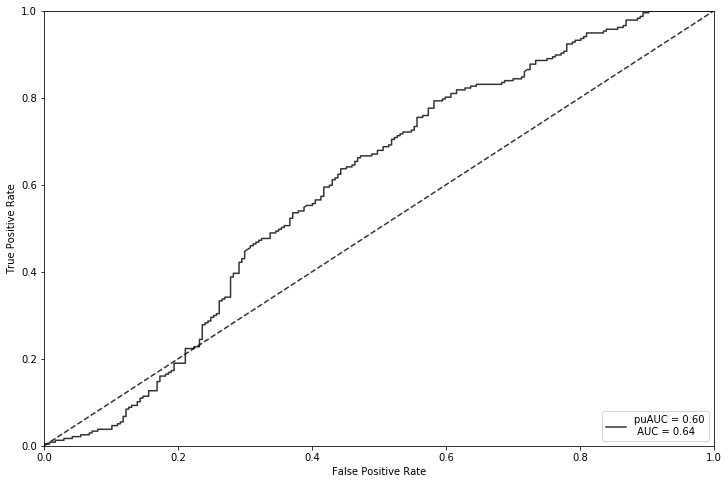

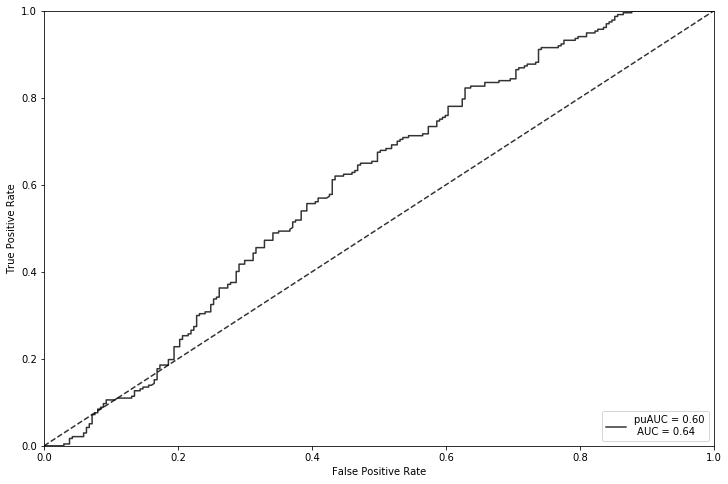

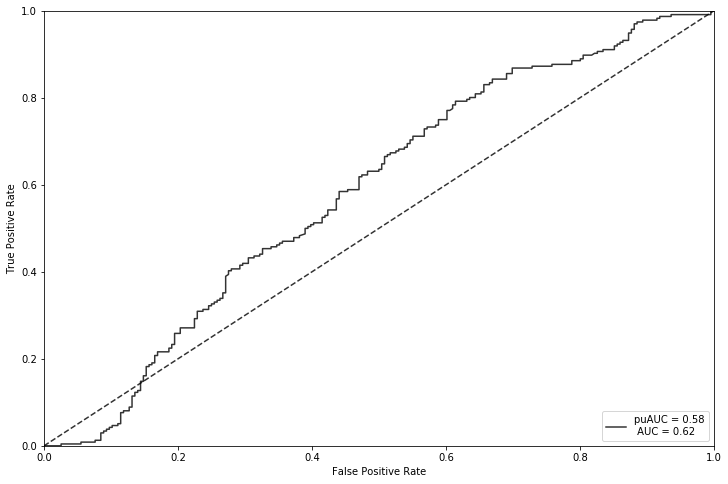

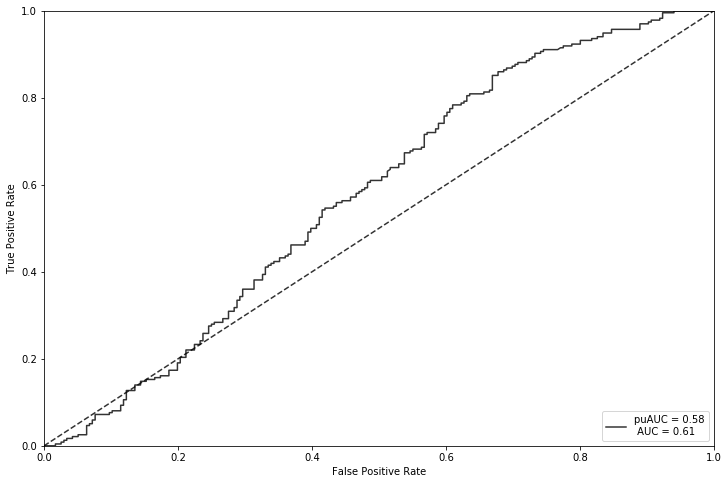

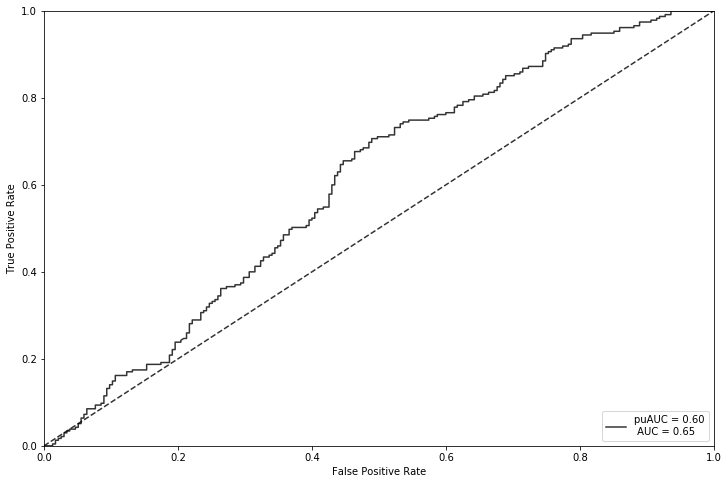

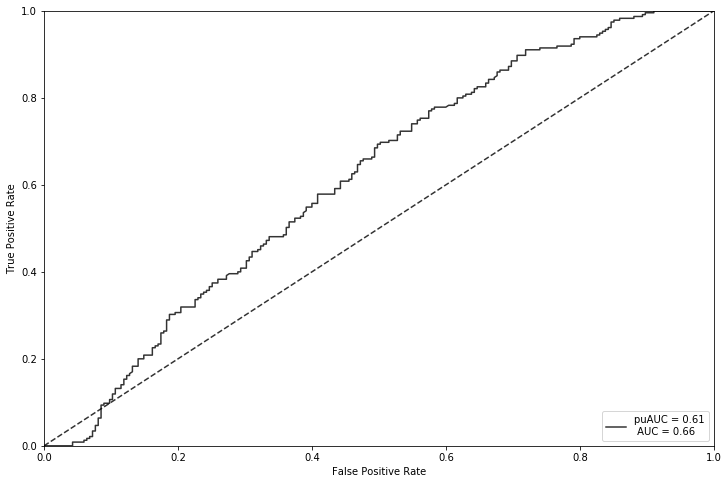

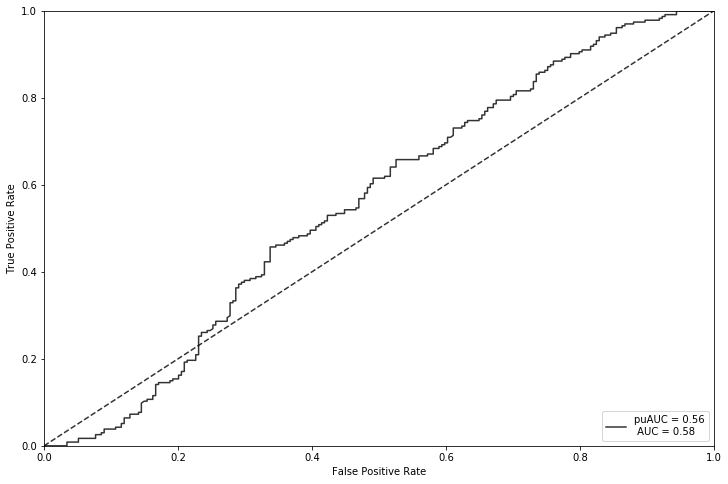

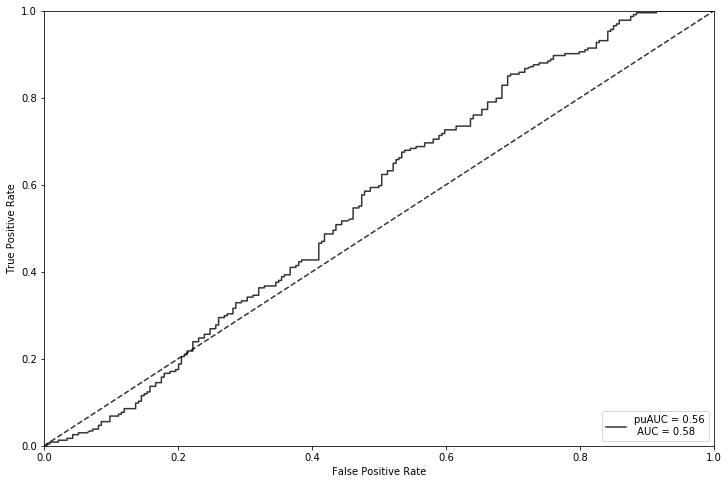

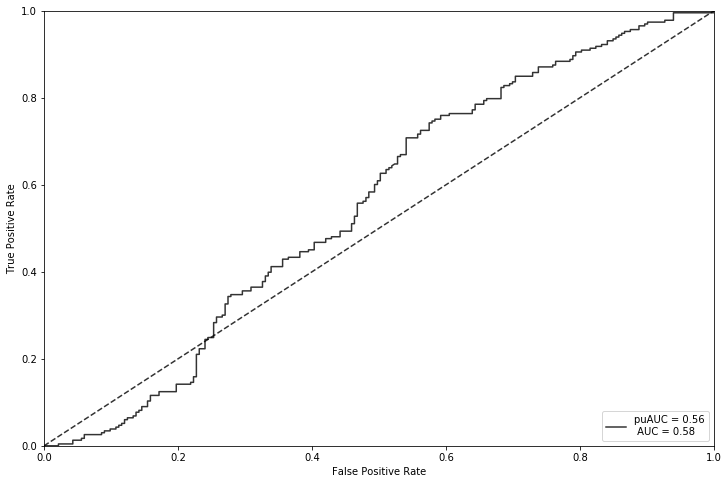

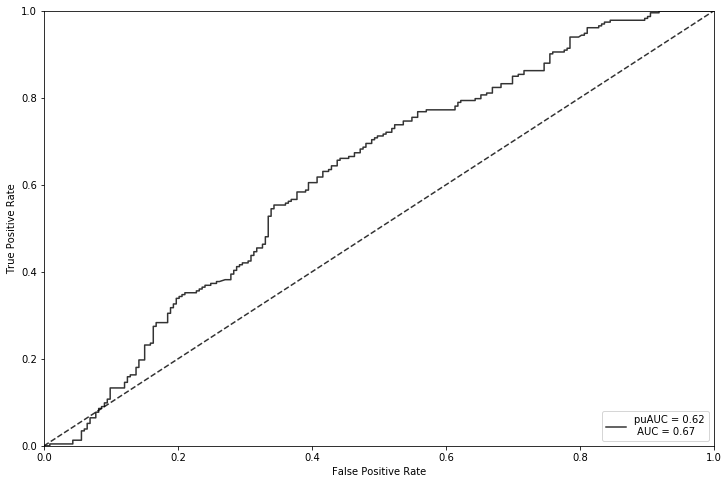

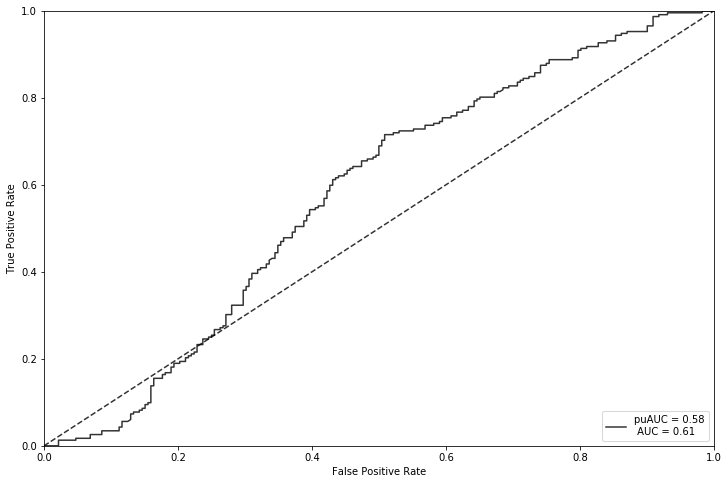

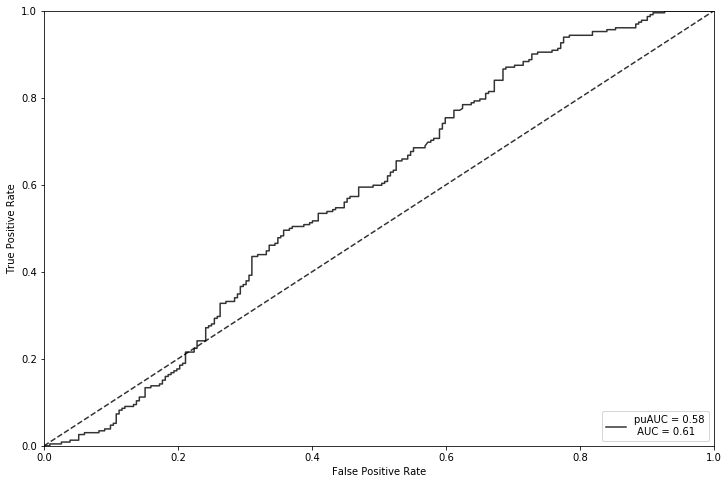

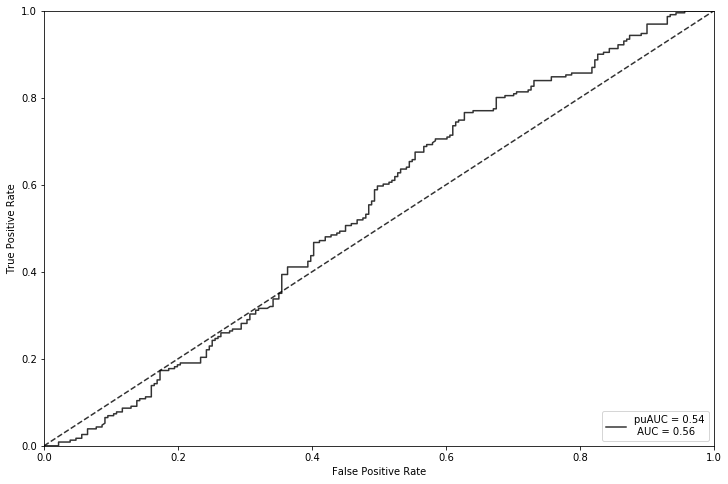

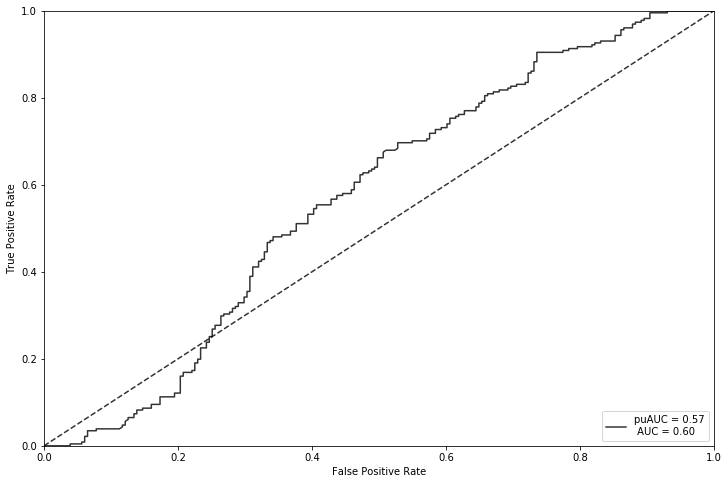

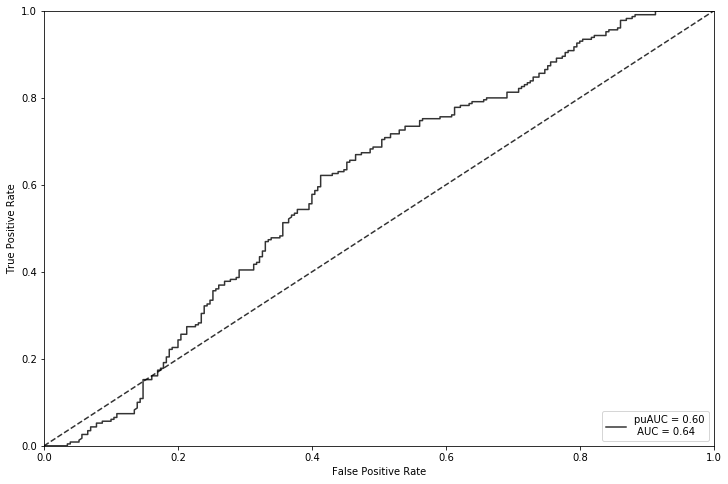

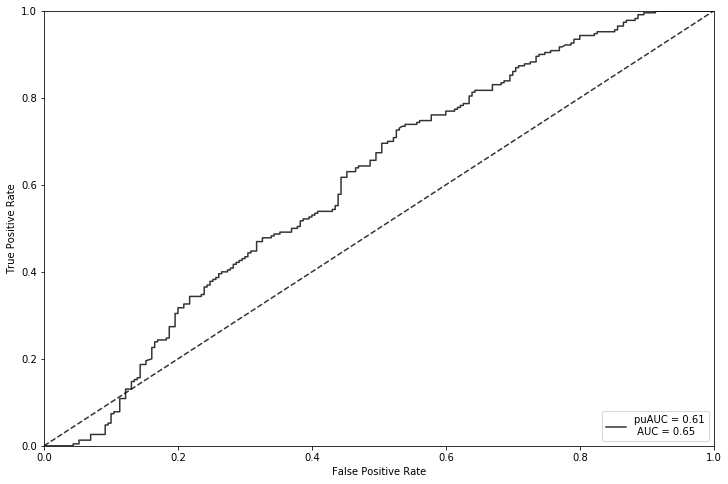

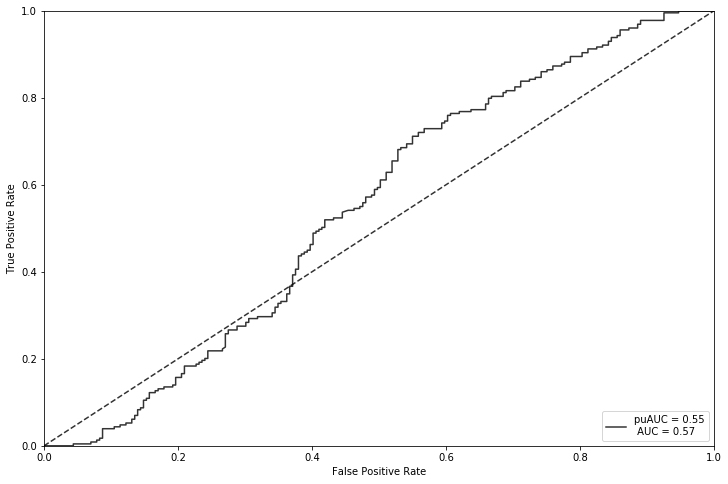

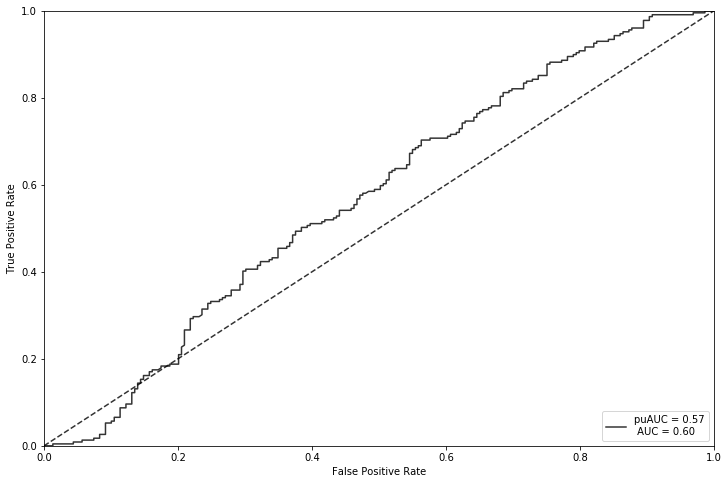

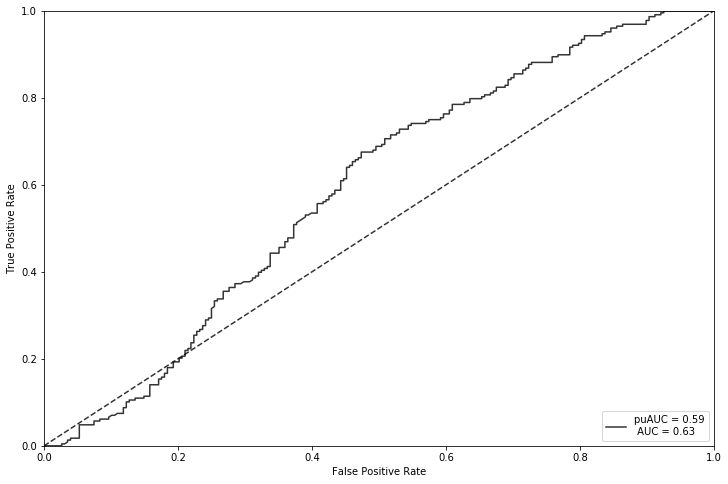

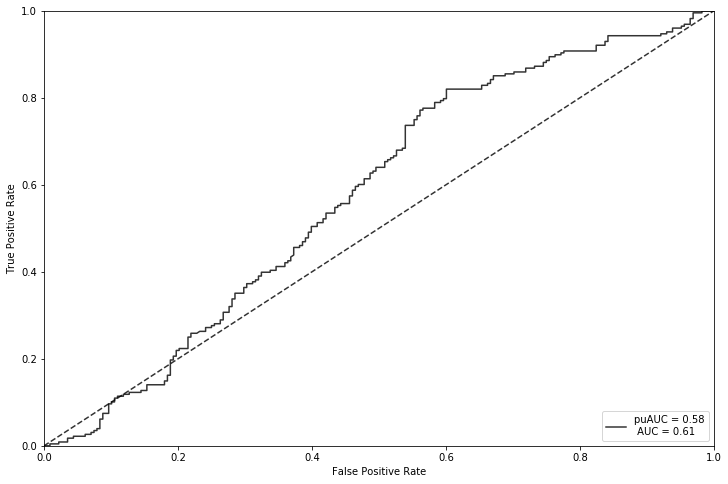

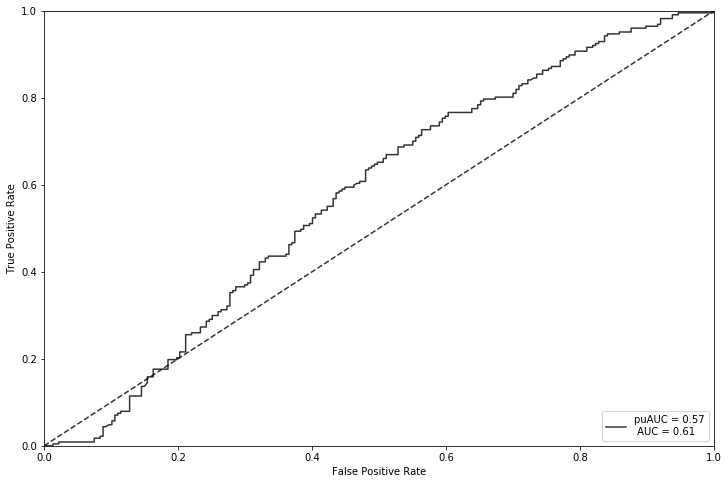

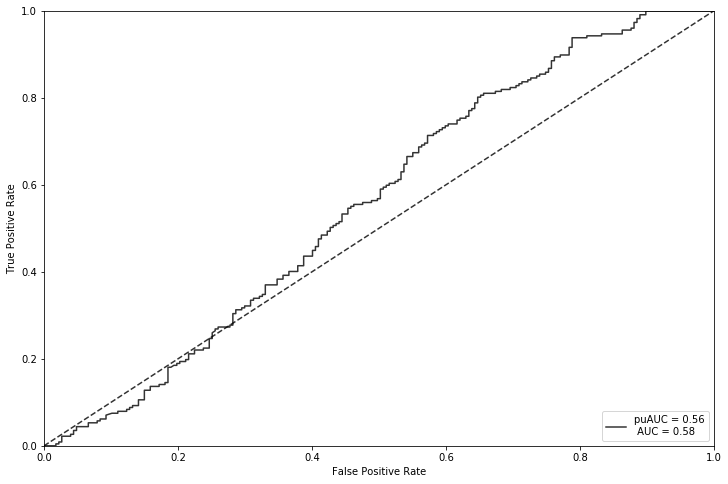

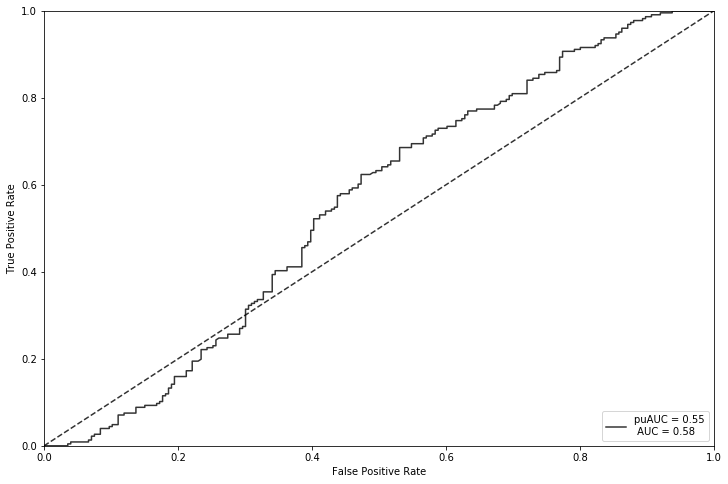

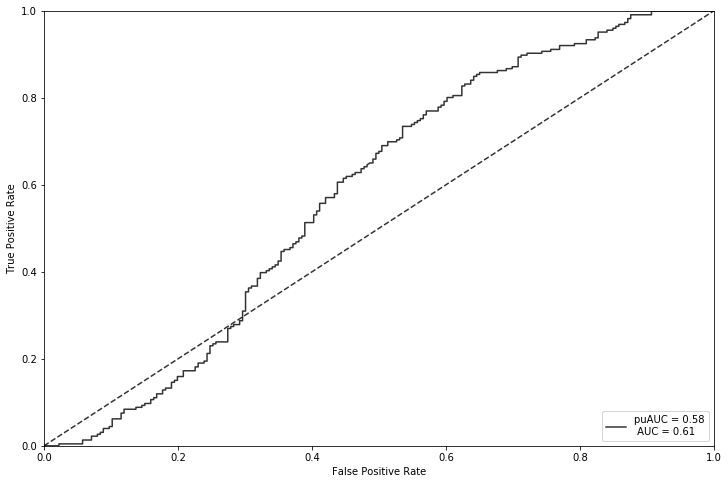

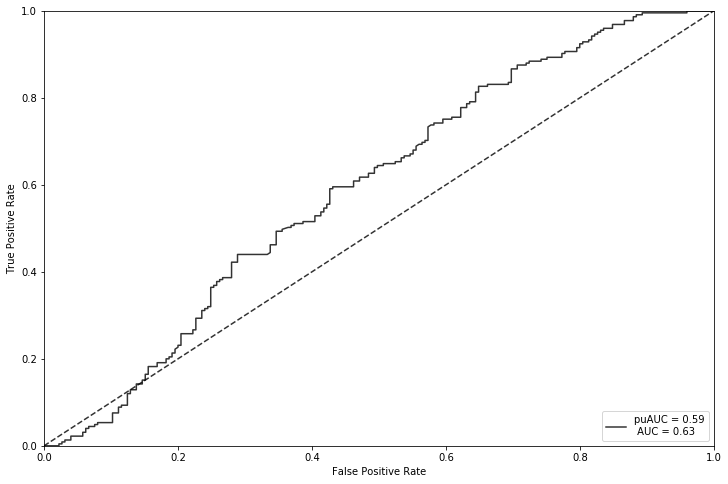

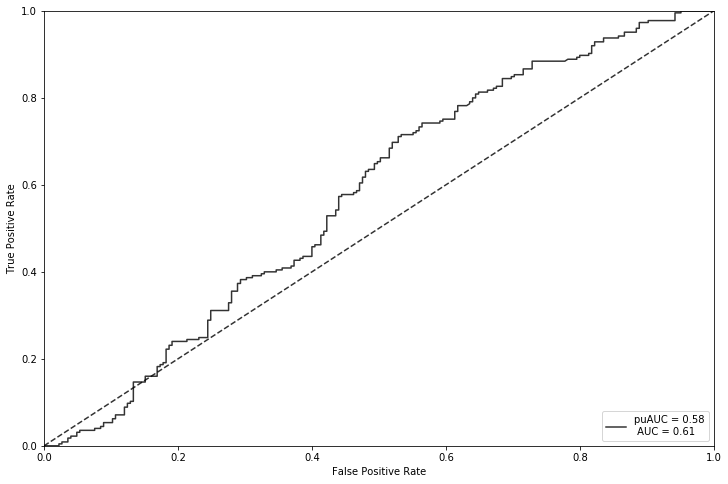

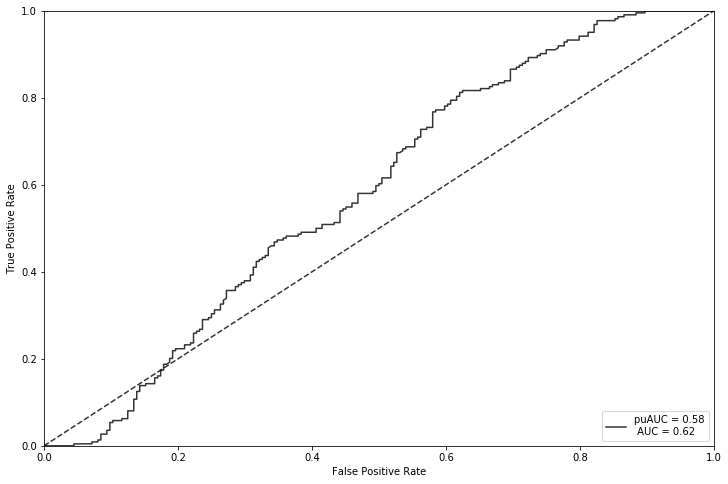

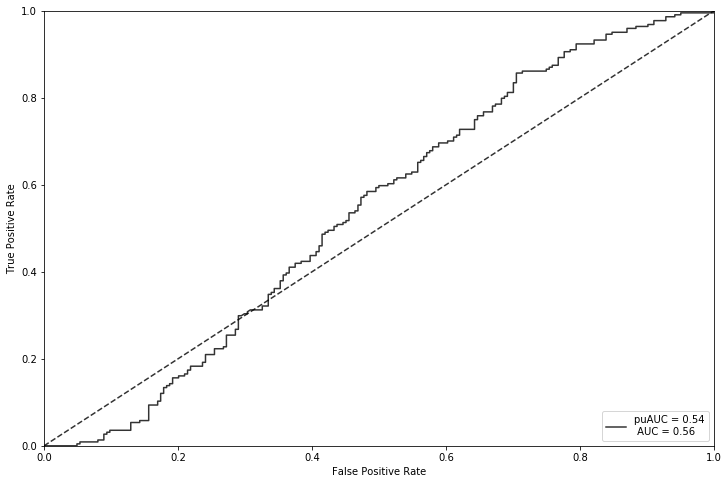

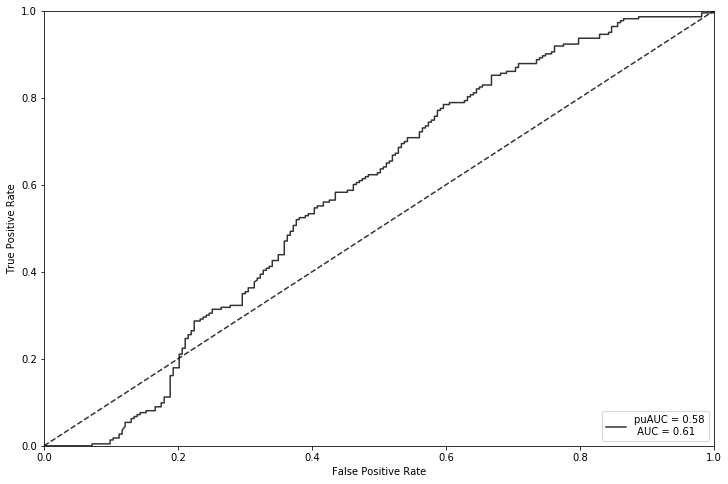

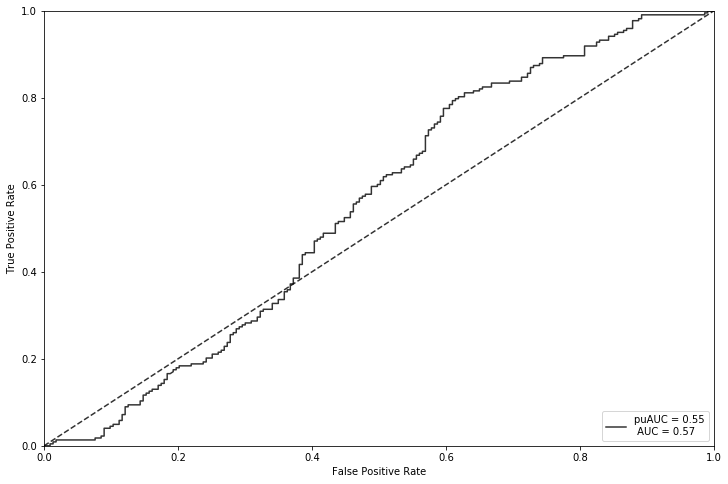

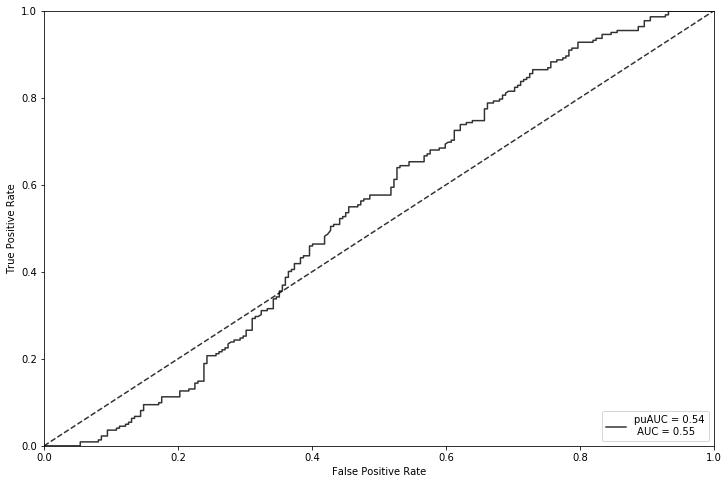

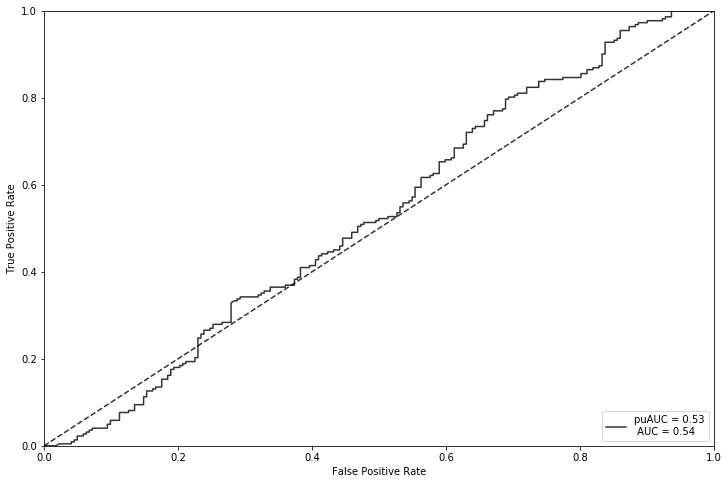

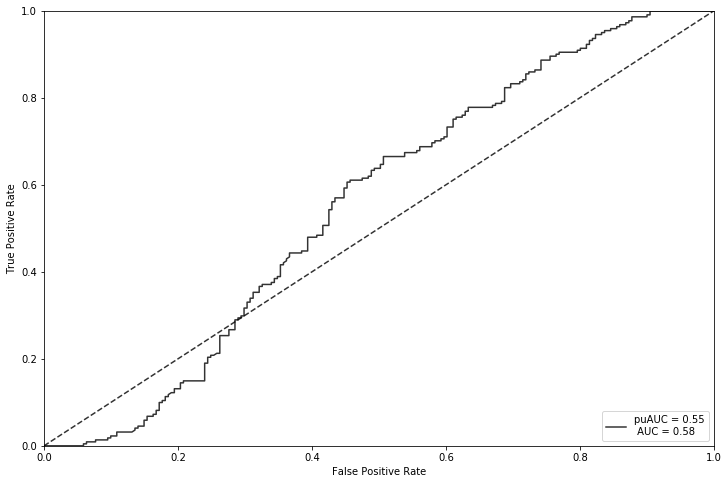

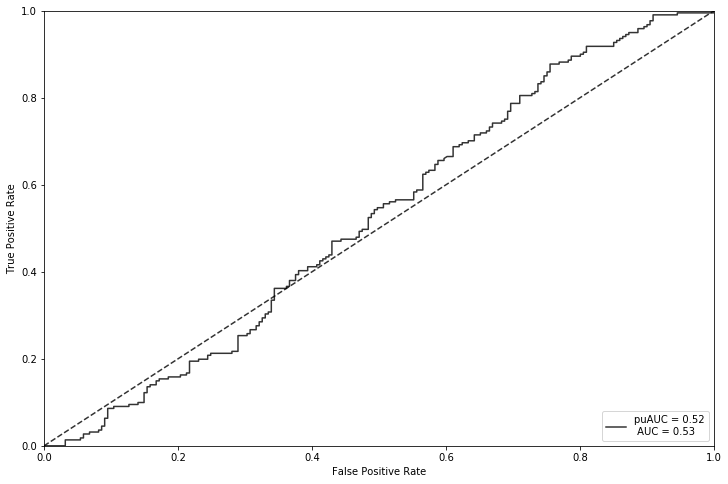

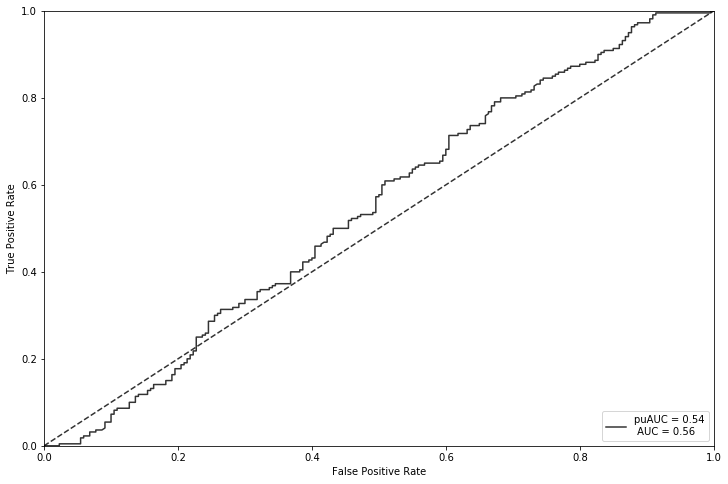

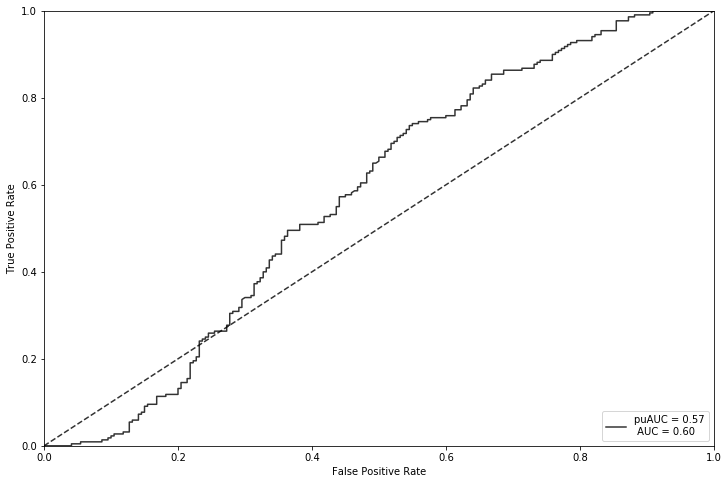

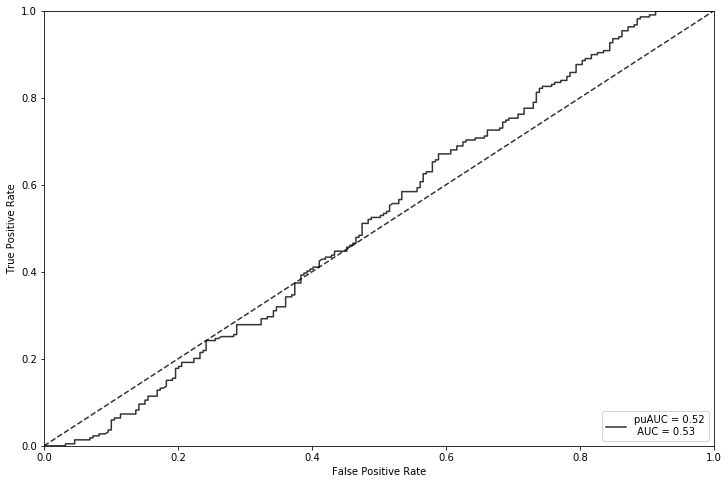

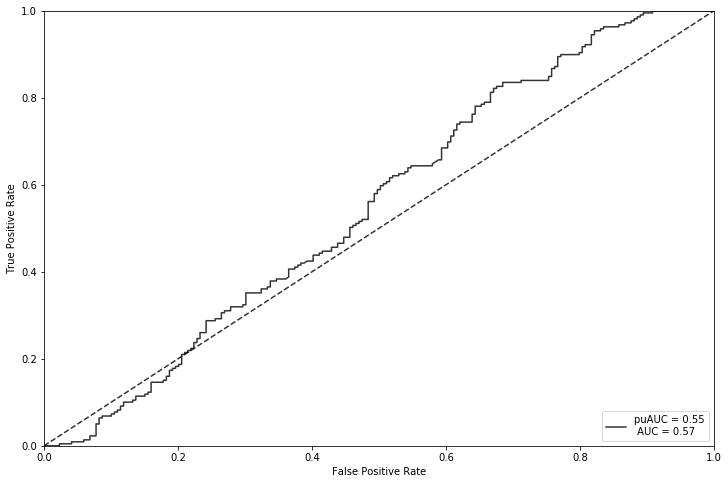

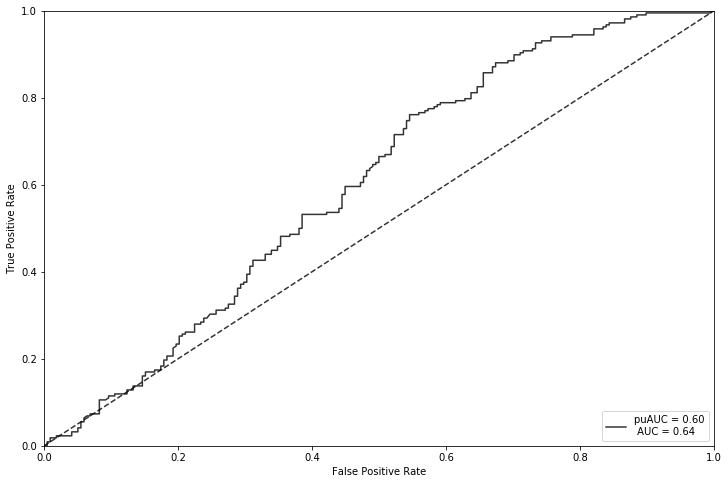

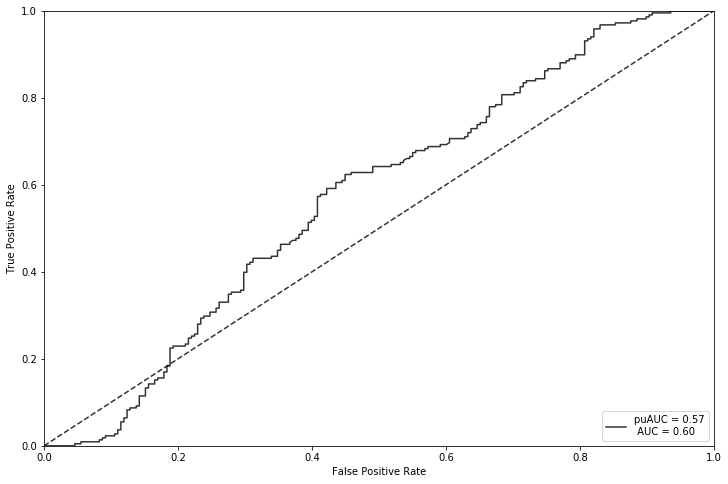

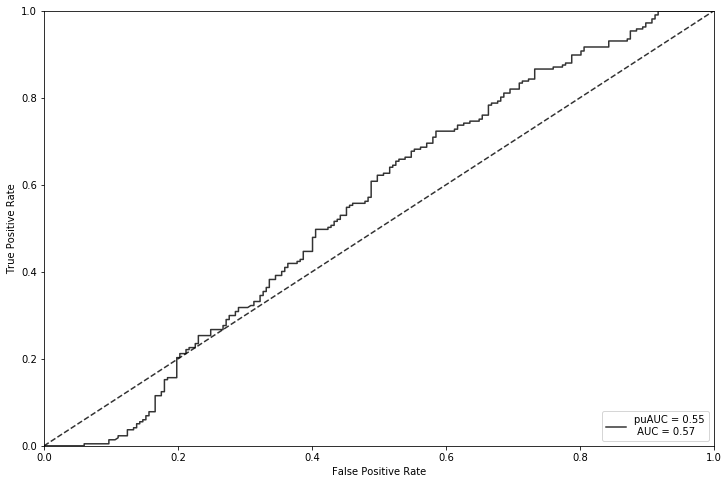

In [6]:
gbs = gbs_base.copy()

n = 579
iterations = 145
auroc = iterations*[0]

#feature importance
imp = (len(gbs.columns) -1) * [0]

for ite in range(iterations):
    
    gbs = gbs.reindex(np.random.permutation(gbs.index))

    fst = int(n/2) #first half
    lst = n - fst  #second half

    df_1 = gbs.head(fst).copy()
    df_2 = gbs.tail(lst).copy()

    train = pd.concat([gesis.sample(n=lst), df_2])
    test = pd.concat([gesis.sample(n=fst), df_1])

    y = train.Umfrage
    X = train.drop(columns=['Umfrage'], axis=1).copy()
    clf = RandomForestClassifier(n_estimators=150, max_depth=4)
    clf.fit(X, y)
    imp = [i+j for i,j in zip(clf.feature_importances_,imp)]

    y_test = test.Umfrage
    X_test = test.drop(columns=['Umfrage'], axis=1).copy()

    preds = [i[1] for i in clf.predict_proba(X_test)]
    auroc[ite] = roc(y_test, preds, ite/iterations, ite)
    
    rem = df_1.drop(columns = ['Umfrage'], axis=1)
    result = [i[1] for i in clf.predict_proba(rem)]
    
    if (gbs.index[np.argmax(result)] > 0.6):
        gbs = gbs.drop(gbs.index[np.argmax(result)]).copy()
        n = n-1
    else:
        print("Total number of iterations: " + str(579 - n))
        break
        
stats = gbs.describe()
stats = stats.round(2)
stats.to_csv(os.path.join(path, 'data/resultStats.csv'), encoding = "ISO-8859-1", index= False)

In [8]:
for i,j in zip(imp, gbs.columns):
    print(j, ':', i)

leicht Vertrauen : 27.891228118743463
Faulheit : 17.722287873323936
Entspannt : 14.40047623692206
wenig kuenstlerisches Interesse : 17.406599405843195
Gesellig : 10.217629724573387
Andere kritisieren : 9.323224022758058
Gruendlich : 9.17259551076514
Nervoes : 22.004193384505193
Phantasievoll : 16.861765722565586


In [9]:
gbs.columns

Index(['leicht Vertrauen', 'Faulheit', 'Entspannt',
       'wenig kuenstlerisches Interesse', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll', 'Umfrage'],
      dtype='object')

### Warning: To run the next code snippet without error, it is necessary to copy paste and rename one of the roc curves created to "roc.png". This was a fast workaround (can be fixed quite fast though).

In [45]:
from PIL import Image

for name in range(579 - n):
    
    img = Image.open(os.path.join(path, 'tex/fig/roc/'+str(name)+'.png'))
    img = img.convert("RGBA")
    
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    img.save(os.path.join(path, 'tex/fig/roc/'+str(name)+'.png'), "PNG")

for ite in range(579 - n):
    background = Image.open(os.path.join(path, 'tex/fig/roc/roc.png'))
    foreground = Image.open(os.path.join(path, 'tex/fig/roc/'+str(ite)+'.png'))
    Image.alpha_composite(background,foreground).save(os.path.join(path, 'tex/fig/roc/roc.png'))

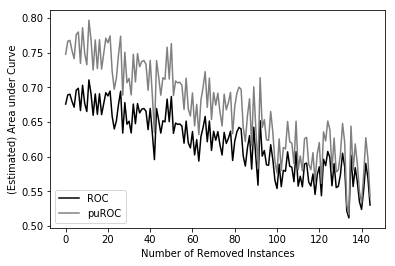

In [46]:
puRoc = []
for i in auroc:
    puRoc.append(puROC(i, 0.29))

plt.ylabel('(Estimated) Area under Curve')
plt.xlabel('Number of Removed Instances')
plt.plot(auroc[:(579 - n)], color='black', label = 'ROC')
plt.plot(puRoc[:(579 - n)], color='grey', label = 'puROC')
plt.legend(loc = 'lower left')

plt.savefig(os.path.join(path, 'tex/fig/roc/AUROC_drop.png'))
plt.show()